# Data-driven modelling of mouse eye movement dynamics: predicting reflexive responses to visual motion and head velocity


This code shows how to load and visualize the data. 


There  are three files that correspond to three recordings '22_a30', '22_a48', '22_a80'. 
In each recording you have time kinematic information vs time for different trials. 
For instance, eye_position contains the eye position of the animal wrt the head. In idx_rec=2 has dimension 670x500. Here 670 is the number of trial and 500 are the time bin in each trial

You can see rapid eye movement in trials 0, 2, 3, 4 ... for instance
While trials 1, 8, 9 ... do not have rapid eye movemnt

We would like to build a models that predict on a moment by moent basis the probability of having a rapid eye movement, given the histroy of velocity/position of head, eye, and visual stimulus. 

### Compute useful metrics

In [1]:

%load_ext autoreload
%autoreload 2
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from copy import deepcopy
from statsmodels.api import OLS
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
import seaborn as sns
import math
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.utils import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler



area=4.0;linethicknes=1.0;
font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42


In [2]:
idx_rec=2 # there are three files that correspond to three mice
local_folder='data/'

data = np.load(local_folder+f"single_recording_{['22_a30', '22_a48', '22_a80'][idx_rec]}.npz", allow_pickle=True)

# Access the description
description = data["description"].item()  # Since it's stored as a dictionary

# Access the arrays
time = data["time"]*0.001
normalized_velocity_profile = data["normalized_velocity_profile"]
trial_types = data["trial_types"]
eye_position = data["eye_position"]
eye_velocity = data["eye_velocity"]
head_velocity = data["head_velocity"]
head_velocity_control = data["head_velocity_control"]
rates = data["rates"]
Rs = data["Rs"]
depth = data["depth"]
layer = data["layer"]
recording = data["recording"]

# I take the 200 ms around the peak to do decoding
#idx_peak=np.where(normalized_velocity_profile>0.945)[0]
idx_peak=np.where(normalized_velocity_profile>0.25)[0]

peak_rates=np.mean(rates[:,:,idx_peak],axis=2)

# Print the description
print(description)

{'time': 'time in seconds within one trial', 'normalized_velocity_profile': 'normalized velocity profile', 'trial_types': 'Trial types for each trial (without selection)', 'eye_position': 'Eye position data for each trial', 'eye_velocity': 'Eye velocity data for each trial', 'head_velocity': 'Head velocity data for each trial', 'head_velocity_control': 'Head velocity control data for each trial, aligned to neural responses', 'rates': 'Neural firing rates for each neuron (n_cells, n_trials, time points)', 'Rs': 'Respective Rs values for each neuron', 'depth': 'Depth values for each neuron', 'layer': 'Layer assignments for each neuron', 'recording': 'Recording identifiers for each neuron'}


In [3]:
# Compute useful quantities

n_trials=np.shape(head_velocity)[0]
dt=np.mean(np.diff(time))


visual_velocity=np.zeros(np.shape(head_velocity))
visual_position=np.zeros(np.shape(head_velocity))
head_position=np.zeros(np.shape(head_velocity))

for idx_trial in range(n_trials):
    visual_velocity[idx_trial,:]=trial_types[idx_trial,1]*normalized_velocity_profile
    visual_position[idx_trial,:]=np.cumsum(visual_velocity[idx_trial,:])*dt
    head_position[idx_trial,:]=np.cumsum(head_velocity[idx_trial,:])*dt


velocity_drift_on_retina_vs_time=visual_velocity-(head_velocity+eye_velocity)
position_drift_on_retina_vs_time=visual_position-(head_position+eye_position)

idx_movement=np.where(normalized_velocity_profile>0.01)[0]


In [4]:
position_drift_on_retina_vs_time[347,:]

array([-1.23604593e-01, -3.26523798e-01, -2.54978538e-01, -4.37143052e-01,
       -3.65905795e-01, -3.42153418e-01, -5.44446993e-01, -5.28576136e-01,
       -3.62222681e-01, -6.44348691e-01, -6.03971033e-01, -6.10916029e-01,
       -7.50698074e-01, -8.51641891e-01, -6.39253330e-01, -6.17112775e-01,
       -6.85472030e-01, -5.43819818e-01, -7.86260856e-01, -5.16644230e-01,
       -4.26129955e-01, -8.27537867e-01, -4.48241401e-01, -3.55566969e-01,
       -4.26469457e-01, -1.35468005e-01, -1.41413539e-01, -3.27520953e-02,
       -4.69484693e-02,  1.57078793e-01,  3.27443131e-01,  2.11007606e-01,
        3.75464678e-01, -2.08816661e-01,  2.69705155e-01, -1.31018821e-01,
       -1.32795723e-01,  1.15975695e-01,  1.07233478e-01,  1.95154913e-01,
        3.42691997e-02, -1.01977186e-02,  2.72505764e-03, -3.19199257e-01,
        6.38007504e-03,  9.39393921e-02, -1.20561003e-01, -3.96088518e-01,
       -5.96073793e-02, -2.17477962e-01, -4.12561761e-01, -9.98538482e-02,
       -2.75429682e-01, -

### Plot head, eye and visual stimulus velocity in a trial 

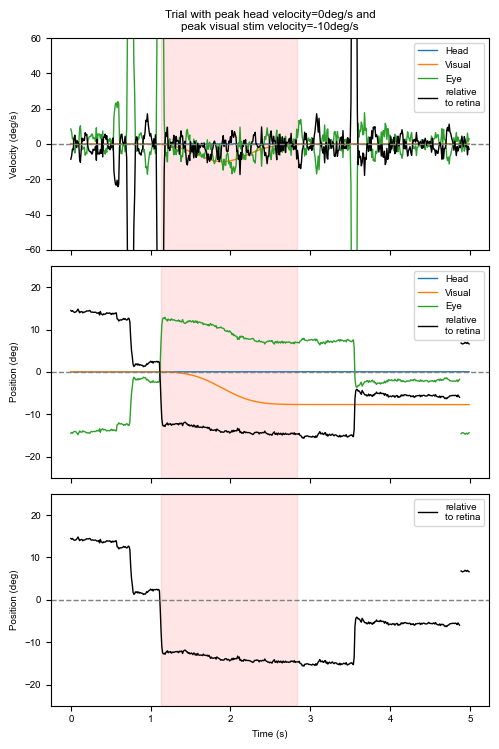

In [5]:
idx_trial=0
#idx_trial=np.where((Trial_Head_Velocity==20)&(Trial_Visual_Velocity==0))[0][0]

nrows,ncols=3,1
fig, axs = plt.subplots(nrows,ncols, figsize=(5*ncols,2.5*nrows), facecolor='w', edgecolor='k',sharex=True)#,sharex=True)
axs = axs.ravel()


axs[0].set_title('Trial with peak head velocity=%ddeg/s and\npeak visual stim velocity=%ddeg/s'%(trial_types[idx_trial,0],trial_types[idx_trial,1]))

# Plot velocities
axs[0].plot(time, head_velocity[idx_trial, :], label="Head")
axs[0].plot(time, visual_velocity[idx_trial, :], label="Visual")
axs[0].plot(time, eye_velocity[idx_trial, :], label="Eye")
axs[0].plot(time, velocity_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[0].set_ylabel("Velocity (deg/s)")
axs[0].legend(loc='best')
axs[0].set_ylim([-60,60])

# Plot positions
axs[1].plot(time, head_position[idx_trial, :], label="Head")
axs[1].plot(time, visual_position[idx_trial, :], label="Visual")
axs[1].plot(time, eye_position[idx_trial, :], label="Eye")
axs[1].plot(time,position_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[1].set_ylabel("Position (deg)")
axs[1].legend(loc='best')
axs[1].set_ylim([-25,25])


axs[2].plot(time,position_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Position (deg)")
axs[2].legend(loc='best')
axs[2].set_ylim([-25,25])

for idx in [0,1,2]:
    axs[idx].axhline(y=0,ls='--',c='grey')
    axs[idx].axvspan(time[idx_movement[0]], time[idx_movement[-1]], color='red', alpha=0.1)


plt.tight_layout()


In [6]:
eye_velocity.shape

(670, 500)

In [7]:
bin = 100
head_velocity_binned=np.zeros((670,bin))
visual_velocity_binned=np.zeros((670,bin))
eye_velocity_binned=np.zeros((670,bin))
eye_velocity_relretina_binned=np.zeros((670,bin))

for idx in range(n_trials):
    eye_velocity_binned[idx,:]= eye_velocity[idx,:].reshape(bin, 500//bin).mean(axis=1)
    eye_velocity_relretina_binned[idx,:]= velocity_drift_on_retina_vs_time[idx,:].reshape(bin, 500//bin).mean(axis=1)
    head_velocity_binned[idx,:]= head_velocity[idx,:].reshape(bin, 500//bin).mean(axis=1)
    visual_velocity_binned[idx,:]= visual_velocity[idx,:].reshape(bin, 500//bin).mean(axis=1)
    
time_binned = time.reshape(bin, 500//bin).mean(axis=1)

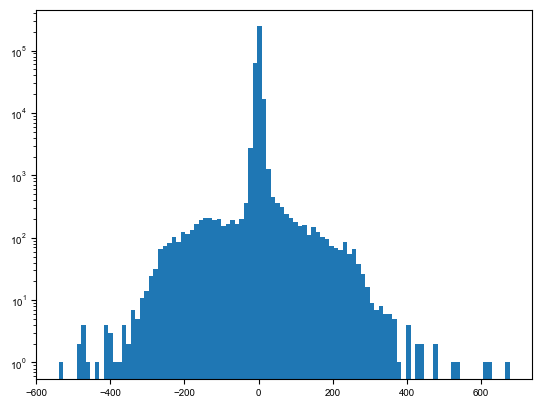

In [8]:
plt.hist(eye_velocity.ravel(),bins = 100)
plt.yscale('log')

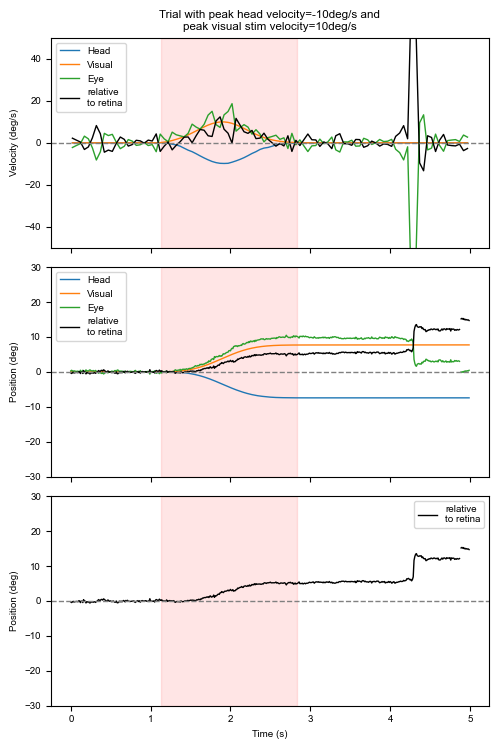

In [9]:
idx_trial=36
#idx_trial=np.where((Trial_Head_Velocity==20)&(Trial_Visual_Velocity==0))[0][0]

nrows,ncols=3,1
fig, axs = plt.subplots(nrows,ncols, figsize=(5*ncols,2.5*nrows), facecolor='w', edgecolor='k',sharex=True)#,sharex=True)
axs = axs.ravel()


axs[0].set_title('Trial with peak head velocity=%ddeg/s and\npeak visual stim velocity=%ddeg/s'%(trial_types[idx_trial,0],trial_types[idx_trial,1]))

# Plot velocities
axs[0].plot(time_binned, head_velocity_binned[idx_trial, :], label="Head")
axs[0].plot(time_binned, visual_velocity_binned[idx_trial, :], label="Visual")
axs[0].plot(time_binned, eye_velocity_binned[idx_trial, :], label="Eye")
axs[0].plot(time_binned, eye_velocity_relretina_binned[idx_trial, :], color="k", label="relative\nto retina")
axs[0].set_ylabel("Velocity (deg/s)")
axs[0].legend(loc='best')
axs[0].set_ylim([-50,50])

# Plot positions
axs[1].plot(time, head_position[idx_trial, :], label="Head")
axs[1].plot(time, visual_position[idx_trial, :], label="Visual")
axs[1].plot(time, eye_position[idx_trial, :], label="Eye")
axs[1].plot(time,position_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[1].set_ylabel("Position (deg)")
axs[1].legend(loc='best')
axs[1].set_ylim([-30,30])


axs[2].plot(time,position_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Position (deg)")
axs[2].legend(loc='best')
axs[2].set_ylim([-30,30])

for idx in [0,1,2]:
    axs[idx].axhline(y=0,ls='--',c='grey')
    axs[idx].axvspan(time[idx_movement[0]], time[idx_movement[-1]], color='red', alpha=0.1)


plt.tight_layout()

Rapid eye movement when eye velocity is around 50 deg/s or more 

Just test time version

In [10]:
for idx in range (49,30,-1):
    rem_1 = np.where(abs(eye_velocity_binned[:,20:60]) > idx+1)
    rem_2 = np.where(abs(eye_velocity_binned[:,20:60]) > idx)
    print(f'mancano: {np.setdiff1d(np.unique(rem_2[0]),np.unique(rem_1[0]))} da >{idx+1} rispetto a >{idx}')
    

mancano: [218] da >50 rispetto a >49
mancano: [180 518] da >49 rispetto a >48
mancano: [] da >48 rispetto a >47
mancano: [] da >47 rispetto a >46
mancano: [] da >46 rispetto a >45
mancano: [172] da >45 rispetto a >44
mancano: [638] da >44 rispetto a >43
mancano: [369] da >43 rispetto a >42
mancano: [239 476 573] da >42 rispetto a >41
mancano: [] da >41 rispetto a >40
mancano: [] da >40 rispetto a >39
mancano: [] da >39 rispetto a >38
mancano: [318] da >38 rispetto a >37
mancano: [] da >37 rispetto a >36
mancano: [] da >36 rispetto a >35
mancano: [] da >35 rispetto a >34
mancano: [240] da >34 rispetto a >33
mancano: [268] da >33 rispetto a >32
mancano: [477] da >32 rispetto a >31


50 deg/s is kept as threshold, these REMs can be added manually eventually

In [11]:
arrem = np.where(abs(eye_velocity_binned[:,20:60]) > 50)
arremc = deepcopy(list(arrem))
datafra = pd.DataFrame()
datafra["n_trial"] = np.unique(arrem[0])
datafra["n_rem"] = np.zeros(len(datafra["n_trial"]))
datafra["n_rem_nomulti"]  = np.zeros(len(datafra["n_trial"]))
k = 0
for i in range(len(datafra["n_trial"])):
    temp = np.count_nonzero(arrem[0] == datafra["n_trial"][i])
    count = 0
    tem_sum = int(datafra["n_rem"].sum())
    datafra.loc[i,"n_rem"] = temp
    #print('tem_sum: ',tem_sum)
    # print('type temp: ', type(temp), temp)
    for j in range(temp):
        if (j+1+tem_sum) < len(arrem[1]):
            if arrem[1][j+1+tem_sum] - arrem[1][j+tem_sum] == 1:
                #maxi = np.max([arrem[1][j+tem_sum],arrem[1][j+1+tem_sum]])
                if np.count_nonzero(arremc[0] == datafra["n_trial"][i]) > 1:
                    arremc[0] = np.delete(arremc[0],j+tem_sum-k)
                    arremc[1] = np.delete(arremc[1],j+tem_sum-k)
                    k += 1
                    count += 1
                #print("maxi",maxi)
                #print("counted",arrem[1][j+1+tem_sum],arrem[1][j+tem_sum])
    #print(f"count for trial {datafra['n_trial'][i]}: {count}")    
    # if temp - count == 0:       
    #     datafra.loc[i,"n_rem_nomulti"] = 1
    # else:
    datafra.loc[i,"n_rem_nomulti"] = temp - count
        
datafra

,n_trial,n_rem,n_rem_nomulti
0,0,1.0,1.0
1,3,1.0,1.0
2,4,3.0,2.0
3,6,2.0,1.0
4,7,2.0,1.0
...,...,...,...
231,653,4.0,3.0
232,655,2.0,1.0
233,656,3.0,2.0
234,663,2.0,1.0


In [12]:
datafra[datafra["n_trial"]==15]

,n_trial,n_rem,n_rem_nomulti
8,15,4.0,2.0


n_rem_nomulti doesn't take into consideration time bins adjacent to eachother, since for very high eye_velocities there could be more than one bins which pass the 50 deg/s threshold

In [13]:
datafra["n_rem_nomulti"].sum()

np.float64(333.0)

In [14]:
arremc[0].shape


(333,)

In [15]:
arremc

[array([  0,   3,   4,   4,   6,   7,  11,  12,  14,  15,  15,  18,  19,
         20,  25,  25,  25,  28,  29,  31,  37,  39,  41,  41,  41,  49,
         54,  55,  55,  55,  60,  60,  60,  63,  65,  77,  78,  78,  87,
         93,  96, 100, 100, 108, 111, 116, 116, 117, 118, 120, 125, 125,
        125, 128, 129, 131, 134, 137, 142, 142, 146, 147, 150, 151, 152,
        154, 154, 163, 164, 167, 173, 178, 179, 182, 183, 183, 185, 185,
        185, 186, 188, 188, 189, 191, 191, 196, 200, 201, 202, 203, 203,
        209, 209, 213, 215, 217, 219, 220, 221, 223, 226, 226, 226, 226,
        227, 228, 233, 233, 238, 243, 243, 248, 251, 251, 254, 255, 256,
        263, 263, 263, 270, 270, 272, 274, 280, 281, 284, 285, 287, 287,
        296, 297, 297, 300, 301, 304, 314, 315, 315, 320, 323, 325, 328,
        328, 330, 332, 332, 335, 335, 336, 337, 340, 341, 341, 342, 343,
        346, 347, 348, 348, 349, 353, 353, 355, 355, 356, 358, 363, 370,
        370, 372, 372, 375, 375, 375, 377, 380, 384

In [16]:
for i in range(arremc[0].shape[0]):
    countp = 0
    head_vel_bin_rem = head_velocity_binned[arremc[0][i],20+arremc[1][i]]
    vis_vel_bin_rem = visual_velocity_binned[arremc[0][i],20+arremc[1][i]]
    print(f"trial n° {arremc[0][i]}")
    print("Head velocity binned at rem: ",head_vel_bin_rem)
    print("Stimulus velocity binned at rem: ",vis_vel_bin_rem)
    wbin = np.where((head_velocity_binned[:,20:60] == head_vel_bin_rem) & (visual_velocity_binned[:,20:60] == vis_vel_bin_rem))
    for j in range(len(wbin[0])):
        # if arremc[0][i] == wbin[0][j]: 
        #     countp += 1
        # else:
            #whar = np.where(arremc[0]==wbin[0][j])
            #for k in range(len(wbin[1])):
        if wbin[0][j] in arremc[0]:
            if head_velocity_binned[wbin[0][j],20+wbin[1][j]] == head_vel_bin_rem and visual_velocity_binned[wbin[0][j],20+wbin[1][j]] == vis_vel_bin_rem:
                countp += 1
    
    print("wbin: ", wbin)
    print("countp: ", countp)
    print(f"probability of rem at head_vel = {head_vel_bin_rem} and vis_vel = {vis_vel_bin_rem} is {countp/len(wbin[0])}")
            
        

trial n° 0
Head velocity binned at rem:  -0.0020558192890320014
Stimulus velocity binned at rem:  -0.08489727163026675
wbin:  (array([0]), array([2]))
countp:  1
probability of rem at head_vel = -0.0020558192890320014 and vis_vel = -0.08489727163026675 is 1.0
trial n° 3
Head velocity binned at rem:  8.132305440444615
Stimulus velocity binned at rem:  4.047503536825461
wbin:  (array([3]), array([26]))
countp:  1
probability of rem at head_vel = 8.132305440444615 and vis_vel = 4.047503536825461 is 1.0
trial n° 4
Head velocity binned at rem:  -18.492906575044447
Stimulus velocity binned at rem:  -18.57269522114911
wbin:  (array([4]), array([20]))
countp:  1
probability of rem at head_vel = -18.492906575044447 and vis_vel = -18.57269522114911 is 1.0
trial n° 4
Head velocity binned at rem:  -5.121716520654511
Stimulus velocity binned at rem:  -5.041642692951221
wbin:  (array([4]), array([28]))
countp:  1
probability of rem at head_vel = -5.121716520654511 and vis_vel = -5.041642692951221 is

Version with an epsilon interval

In [17]:
for i in range(arremc[0].shape[0]):
    countp = 0
    eps = 0.001
    head_vel_bin_rem = head_velocity_binned[arremc[0][i],20+arremc[1][i]]
    vis_vel_bin_rem = visual_velocity_binned[arremc[0][i],20+arremc[1][i]]
    print(f"trial n° {arremc[0][i]}")
    print("Head velocity binned at rem: ",head_vel_bin_rem)
    print("Stimulus velocity binned at rem: ",vis_vel_bin_rem)
    wbin = np.where((head_velocity_binned[:,20:60] > head_vel_bin_rem-eps) & (head_velocity_binned[:,20:60] < head_vel_bin_rem+eps) & (visual_velocity_binned[:,20:60] > vis_vel_bin_rem-eps) & (visual_velocity_binned[:,20:60] < vis_vel_bin_rem+eps))
    for j in range(len(wbin[0])):
        # if arremc[0][i] == wbin[0][j]: 
        #     countp += 1
        # else:
            #whar = np.where(arremc[0]==wbin[0][j])
            #for k in range(len(wbin[1])):
        if wbin[0][j] in arremc[0]:
            if (head_velocity_binned[wbin[0][j],20+wbin[1][j]] > head_vel_bin_rem-eps) and (head_velocity_binned[wbin[0][j],20+wbin[1][j]] < head_vel_bin_rem+eps) and (visual_velocity_binned[wbin[0][j],20+wbin[1][j]] > vis_vel_bin_rem-eps) and (visual_velocity_binned[wbin[0][j],20+wbin[1][j]] < vis_vel_bin_rem+eps):
                countp += 1
    
    print("wbin: ", wbin)
    print("countp :", countp)
    print(f"probability of rem at head_vel = {head_vel_bin_rem} and vis_vel = {vis_vel_bin_rem} is {countp/len(wbin[0])}")

trial n° 0
Head velocity binned at rem:  -0.0020558192890320014
Stimulus velocity binned at rem:  -0.08489727163026675
wbin:  (array([  0, 144, 211, 588, 592]), array([2, 2, 2, 2, 2]))
countp : 1
probability of rem at head_vel = -0.0020558192890320014 and vis_vel = -0.08489727163026675 is 0.2
trial n° 3
Head velocity binned at rem:  8.132305440444615
Stimulus velocity binned at rem:  4.047503536825461
wbin:  (array([3]), array([26]))
countp : 1
probability of rem at head_vel = 8.132305440444615 and vis_vel = 4.047503536825461 is 1.0
trial n° 4
Head velocity binned at rem:  -18.492906575044447
Stimulus velocity binned at rem:  -18.57269522114911
wbin:  (array([4]), array([20]))
countp : 1
probability of rem at head_vel = -18.492906575044447 and vis_vel = -18.57269522114911 is 1.0
trial n° 4
Head velocity binned at rem:  -5.121716520654511
Stimulus velocity binned at rem:  -5.041642692951221
wbin:  (array([  4, 152]), array([28, 28]))
countp : 2
probability of rem at head_vel = -5.121716

(array([2.4000e+02, 2.1000e+02, 3.0000e+01, 1.0800e+02, 1.2800e+02,
        4.0000e+00, 4.1000e+01, 1.5000e+02, 4.9000e+01, 0.0000e+00,
        4.5000e+01, 1.1000e+02, 8.4000e+01, 1.0000e+00, 3.0000e+00,
        9.0000e+01, 9.3000e+01, 5.3000e+01, 1.0000e+00, 5.0000e+00,
        1.0800e+02, 1.0600e+02, 2.1000e+01, 0.0000e+00, 3.4000e+01,
        5.5400e+02, 4.3100e+02, 1.8200e+02, 1.6100e+02, 2.6500e+02,
        2.2600e+02, 2.1700e+02, 1.7000e+02, 1.0400e+02, 3.5300e+02,
        9.9000e+01, 2.0500e+02, 2.3400e+02, 1.6500e+02, 2.7900e+02,
        1.4200e+02, 3.5500e+02, 2.0400e+02, 2.9900e+02, 2.8100e+02,
        3.3600e+02, 4.1000e+02, 4.7800e+02, 7.4500e+02, 2.4350e+04,
        2.5462e+04, 7.3200e+02, 4.6700e+02, 4.1900e+02, 3.1700e+02,
        3.0100e+02, 2.7400e+02, 1.8300e+02, 3.8100e+02, 1.3700e+02,
        2.8600e+02, 1.6100e+02, 2.0600e+02, 2.3800e+02, 8.3000e+01,
        3.5800e+02, 1.1600e+02, 1.8200e+02, 2.1500e+02, 1.9000e+02,
        2.8900e+02, 1.2000e+02, 2.0700e+02, 4.45

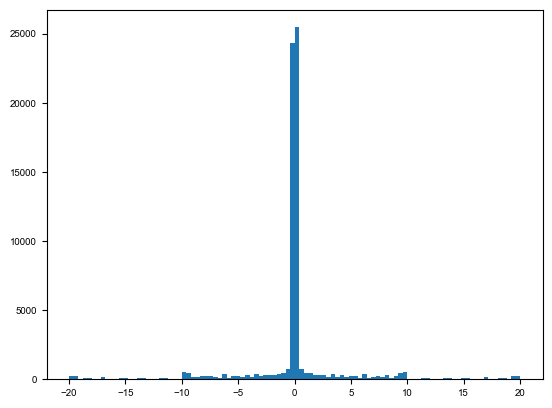

In [18]:
plt.hist(head_velocity_binned.ravel(),bins = 100)

step di 5, parti da 22.5 -> 17.5, 17.5 -> 12.5. discretizzazione velocità. 

Matrici per head_velocity, visual velocity. 

In [19]:
arrem

(array([  0,   3,   4,   4,   4,   6,   6,   7,   7,  11,  12,  14,  14,
         15,  15,  15,  15,  18,  19,  20,  20,  25,  25,  25,  25,  25,
         25,  28,  29,  29,  31,  31,  37,  37,  39,  39,  41,  41,  41,
         41,  49,  49,  54,  55,  55,  55,  55,  55,  60,  60,  60,  60,
         63,  63,  65,  65,  77,  77,  78,  78,  78,  78,  87,  87,  93,
         93,  96, 100, 100, 100, 100, 108, 108, 111, 111, 116, 116, 116,
        117, 117, 118, 118, 120, 120, 125, 125, 125, 125, 128, 128, 129,
        131, 131, 134, 134, 137, 142, 142, 142, 146, 147, 147, 147, 147,
        147, 147, 147, 147, 150, 150, 151, 151, 152, 152, 154, 154, 154,
        154, 163, 164, 164, 164, 167, 173, 173, 178, 179, 182, 183, 183,
        183, 183, 185, 185, 185, 185, 185, 186, 188, 188, 188, 189, 189,
        191, 191, 191, 191, 196, 200, 200, 201, 201, 202, 203, 203, 203,
        203, 209, 209, 209, 213, 215, 217, 219, 219, 220, 221, 221, 223,
        223, 226, 226, 226, 226, 226, 226, 227, 228

## Mathematical POV

### Binning head and stimulus velocity with 5 deg/s steps

(array([  3769.,   3414.,  10652.,  13523., 272284.,  13464.,  10681.,
          3380.,   3833.]),
 array([-22.5, -17.5, -12.5,  -7.5,  -2.5,   2.5,   7.5,  12.5,  17.5,
         22.5]),
 <BarContainer object of 9 artists>)

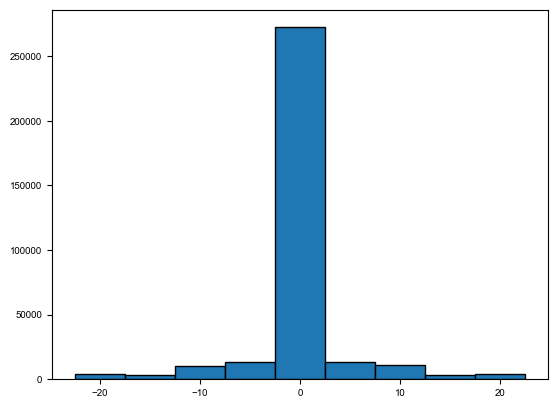

In [19]:
plt.hist(head_velocity.flatten(),bins = np.linspace(-22.5, 22.5, 10),edgecolor='black')

(array([  2937.,   2403.,   8748.,  11077., 284440.,  11020.,   8675.,
          2565.,   3135.]),
 array([-22.5, -17.5, -12.5,  -7.5,  -2.5,   2.5,   7.5,  12.5,  17.5,
         22.5]),
 <BarContainer object of 9 artists>)

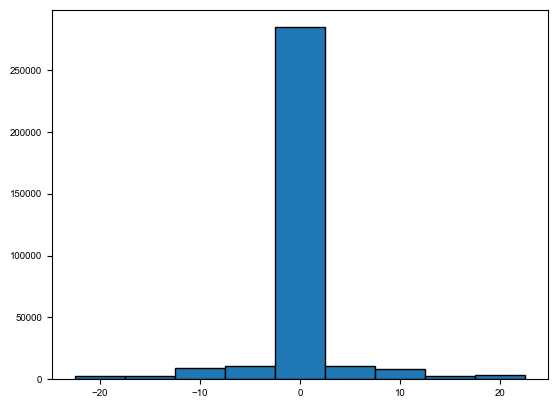

In [20]:
plt.hist(visual_velocity.flatten(),bins = np.linspace(-22.5, 22.5, 10),edgecolor='black')

In [21]:
binv = np.linspace(-22.5, 22.5, 10)

for idx in range(n_trials):
    head_velocity_binned[idx,:]= -20+(np.digitize(head_velocity_binned[idx,:], binv)-1)*5
    visual_velocity_binned[idx,:]= -20+(np.digitize(visual_velocity_binned[idx,:], binv)-1)*5

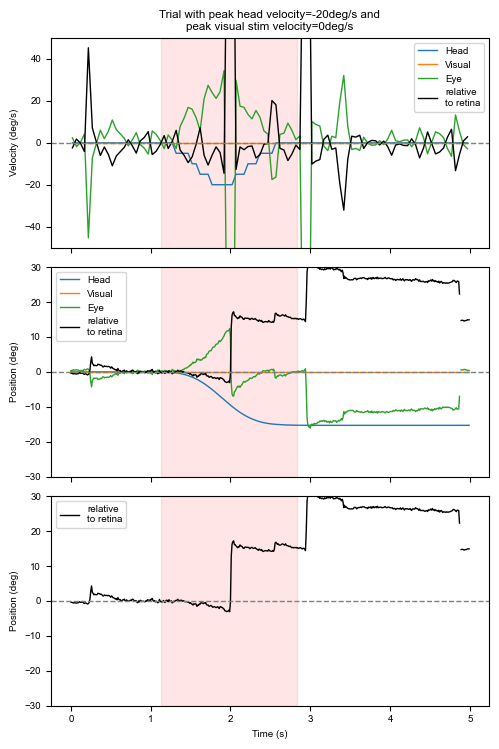

In [22]:
idx_trial=15
#idx_trial=np.where((Trial_Head_Velocity==20)&(Trial_Visual_Velocity==0))[0][0]

nrows,ncols=3,1
fig, axs = plt.subplots(nrows,ncols, figsize=(5*ncols,2.5*nrows), facecolor='w', edgecolor='k',sharex=True)#,sharex=True)
axs = axs.ravel()


axs[0].set_title('Trial with peak head velocity=%ddeg/s and\npeak visual stim velocity=%ddeg/s'%(trial_types[idx_trial,0],trial_types[idx_trial,1]))

# Plot velocities
axs[0].plot(time_binned, head_velocity_binned[idx_trial, :], label="Head")
axs[0].plot(time_binned, visual_velocity_binned[idx_trial, :], label="Visual")
axs[0].plot(time_binned, eye_velocity_binned[idx_trial, :], label="Eye")
axs[0].plot(time_binned, eye_velocity_relretina_binned[idx_trial, :], color="k", label="relative\nto retina")
axs[0].set_ylabel("Velocity (deg/s)")
axs[0].legend(loc='best')
axs[0].set_ylim([-50,50])

# Plot positions
axs[1].plot(time, head_position[idx_trial, :], label="Head")
axs[1].plot(time, visual_position[idx_trial, :], label="Visual")
axs[1].plot(time, eye_position[idx_trial, :], label="Eye")
axs[1].plot(time,position_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[1].set_ylabel("Position (deg)")
axs[1].legend(loc='best')
axs[1].set_ylim([-30,30])


axs[2].plot(time,position_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Position (deg)")
axs[2].legend(loc='best')
axs[2].set_ylim([-30,30])

for idx in [0,1,2]:
    axs[idx].axhline(y=0,ls='--',c='grey')
    axs[idx].axvspan(time[idx_movement[0]], time[idx_movement[-1]], color='red', alpha=0.1)


plt.tight_layout()

In [23]:
arremc[0].shape[0]

333

In [24]:
np.unique(head_velocity_binned)[1]

np.float64(-15.0)

In [25]:


# for i in range(arremc[0].shape[0]):
#     countp = 0
#     head_vel_bin_rem = head_velocity_binned[arremc[0][i],20+arremc[1][i]]
#     vis_vel_bin_rem = visual_velocity_binned[arremc[0][i],20+arremc[1][i]]
#     print(f"trial n° {arremc[0][i]}")
#     print("Head velocity binned at rem: ",head_vel_bin_rem)
#     print("Stimulus velocity binned at rem: ",vis_vel_bin_rem)
#     wbin = np.where((head_velocity_binned[:,20:60] == head_vel_bin_rem) & (visual_velocity_binned[:,20:60] == vis_vel_bin_rem))
#     for j in range(len(wbin[0])):
#         # if arremc[0][i] == wbin[0][j]: 
#         #     countp += 1
#         # else:
#             #whar = np.where(arremc[0]==wbin[0][j])
#             #for k in range(len(wbin[1])):
#         if wbin[0][j] in arremc[0]:
#             if head_velocity_binned[wbin[0][j],20+wbin[1][j]] == head_vel_bin_rem and visual_velocity_binned[wbin[0][j],20+wbin[1][j]] == vis_vel_bin_rem:
#                 countp += 1
    
#     print("wbin: ", wbin)
#     print("countp: ", countp)
#     print(f"probability of rem at head_vel = {head_vel_bin_rem} and vis_vel = {vis_vel_bin_rem} is {countp/len(wbin[0])}")
;  

''

In [26]:
mprob = np.zeros((9,9))

for i in range(len(np.unique(head_velocity_binned))):
    for j in range(len(np.unique(visual_velocity_binned))):
        countp = 0
        head_vel_bin_rem = np.unique(head_velocity_binned)[i]
        vis_vel_bin_rem = np.unique(visual_velocity_binned)[j]
        #print(f"trial n° {arremc[0][i]}")
        print("Head velocity binned at rem: ",head_vel_bin_rem)
        print("Stimulus velocity binned at rem: ",vis_vel_bin_rem)
        wbin = np.where((head_velocity_binned[:,20:60] == head_vel_bin_rem) & (visual_velocity_binned[:,20:60] == vis_vel_bin_rem))
        for h in range(len(wbin[0])):
            # if arremc[0][i] == wbin[0][j]: 
            #     countp += 1
            # else:
                #whar = np.where(arremc[0]==wbin[0][j])
                #for k in range(len(wbin[1])):
            whar = np.where(arremc[0]==wbin[0][h])
            #print("whar: ", whar)
            for k in whar[0]:
                if arremc[1][k] == wbin[1][h]:
                    countp += 1
        

        print("wbin: ", wbin)
        print("countp: ", countp)
        if countp >0:
            print(f"probability of rem at head_vel = {head_vel_bin_rem} and vis_vel = {vis_vel_bin_rem} is {countp/len(wbin[0])}")
            mprob[i,j] = countp/len(wbin[0])
        else:
            mprob[i,j] = 0    

Head velocity binned at rem:  -20.0
Stimulus velocity binned at rem:  -20.0
wbin:  (array([  4,   4,   4,   4,   4,   4,   9,   9,   9,   9,   9,   9,  31,
        31,  31,  31,  31,  31,  44,  44,  44,  44,  44,  44,  51,  51,
        51,  51,  51,  51,  65,  65,  65,  65,  65,  65,  72,  72,  72,
        72,  72,  72,  83,  83,  83,  83,  83,  83,  94,  94,  94,  94,
        94,  94,  99,  99,  99,  99,  99,  99, 119, 119, 119, 119, 119,
       119, 152, 152, 152, 152, 152, 152, 181, 181, 181, 181, 181, 181,
       222, 222, 222, 222, 222, 222, 231, 231, 231, 231, 231, 231, 236,
       236, 236, 236, 236, 236, 249, 249, 249, 249, 249, 249, 288, 288,
       288, 288, 288, 288, 290, 290, 290, 290, 290, 290, 299, 299, 299,
       299, 299, 299, 321, 321, 321, 321, 321, 321, 382, 382, 382, 382,
       382, 382, 398, 398, 398, 398, 398, 398, 403, 403, 403, 403, 403,
       403, 410, 410, 410, 410, 410, 410, 420, 420, 420, 420, 420, 420,
       431, 431, 431, 431, 431, 431, 488, 488, 488, 

In [27]:
mprob

array([[0.01470588, 0.        , 0.01041667, 0.        , 0.05263158,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00490196, 0.03645833, 0.        , 0.05701754,
        0.        , 0.        , 0.        , 0.        ],
       [0.00666667, 0.        , 0.01228501, 0.01098901, 0.01233184,
        0.        , 0.02777778, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00561798, 0.01274363,
        0.02077922, 0.05555556, 0.        , 0.        ],
       [0.01111111, 0.01111111, 0.00425532, 0.00896861, 0.00886898,
        0.0115894 , 0.01256281, 0.01190476, 0.04166667],
       [0.        , 0.        , 0.02941176, 0.01955307, 0.007109  ,
        0.01576873, 0.0097561 , 0.        , 0.        ],
       [0.        , 0.        , 0.02287582, 0.        , 0.01988304,
        0.01568627, 0.00437637, 0.        , 0.01724138],
       [0.        , 0.        , 0.        , 0.        , 0.03603604,
        0.        , 0.03333333, 0.00877193, 0.        ],


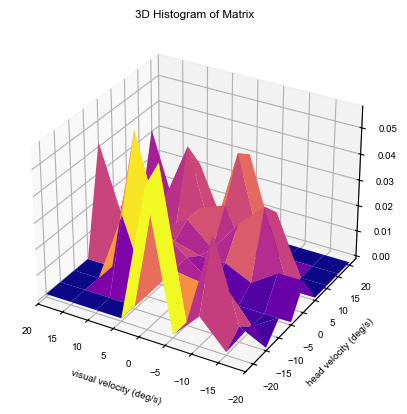

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

matrix = mprob

rows, cols = matrix.shape
x_vals = np.linspace(-20, 20, cols)
y_vals = np.linspace(-20, 20, rows)
x, y = np.meshgrid(x_vals, y_vals)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, matrix, cmap='plasma')

ax.set_xlim(20, -20)

ax.set_xlabel('visual velocity (deg/s)')
ax.set_ylabel('head velocity (deg/s)')
ax.set_zlabel('probability of rem')
ax.set_title('3D Histogram of Matrix')
plt.show()

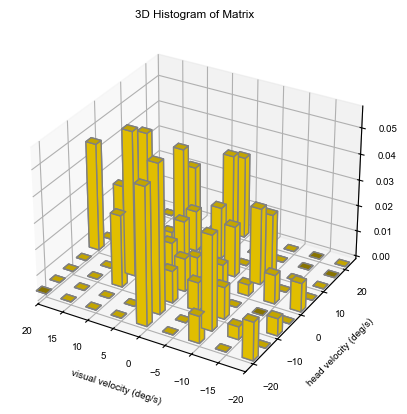

In [29]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(x_vals, y_vals)

# Flatten the grid and values for bar3d
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)  # Bottom of the bars (z=0)
dx = dy = 2       # Width and depth of each bar
dz = matrix.flatten() # Height of bars (the actual values)

ax.bar3d(x, y, z, dx, dy, dz, shade=True, color='gold', edgecolor='gray')

ax.set_xlim(20, -20)

ax.set_xlabel('visual velocity (deg/s)')
ax.set_ylabel('head velocity (deg/s)')
ax.set_zlabel('probability of rem')
ax.set_title('3D Histogram of Matrix')

plt.show()

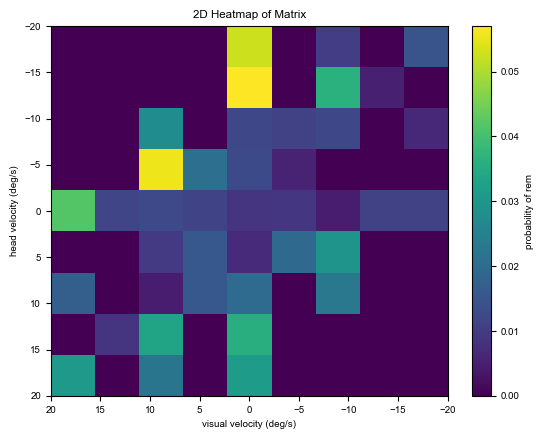

In [30]:
fig, ax = plt.subplots()

im = ax.imshow(matrix, cmap='viridis', aspect='auto',
               extent=[x_vals.min(), x_vals.max(), y_vals.max(), y_vals.min()])

ax.set_xlabel('visual velocity (deg/s)')
ax.set_ylabel('head velocity (deg/s)')
ax.set_title('2D Heatmap of Matrix')
cbar = fig.colorbar(im)
cbar.set_label('probability of rem')

ax.set_xlim(20, -20) 

plt.show()

In [31]:
dprob = pd.DataFrame(mprob, index=np.linspace(-20, 20, mprob.shape[0], dtype=int), columns=np.linspace(-20, 20, mprob.shape[0], dtype=int))

dprob

,-20,-15,-10,-5,0,5,10,15,20
-20,0.014706,0.000000,0.010417,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000
-15,0.000000,0.004902,0.036458,0.000000,0.057018,0.000000,0.000000,0.000000,0.000000
-10,0.006667,0.000000,0.012285,0.010989,0.012332,0.000000,0.027778,0.000000,0.000000
-5,0.000000,0.000000,0.000000,0.005618,0.012744,0.020779,0.055556,0.000000,0.000000
0,0.011111,0.011111,0.004255,0.008969,0.008869,0.011589,0.012563,0.011905,0.041667
5,0.000000,0.000000,0.029412,0.019553,0.007109,0.015769,0.009756,0.000000,0.000000
10,0.000000,0.000000,0.022876,0.000000,0.019883,0.015686,0.004376,0.000000,0.017241
15,0.000000,0.000000,0.000000,0.000000,0.036036,0.000000,0.033333,0.008772,0.000000
20,0.000000,0.000000,0.000000,0.000000,0.031532,0.000000,0.022222,0.000000,0.030702


Trials 11, 172, 375, 638 weird

### Binning head and stimulus velocity with 2.5 deg/s steps

(array([  2563.,   2186.,   1653.,   1577.,   6457.,   6386.,   6463.,
          9240., 261878.,   9187.,   6477.,   6344.,   6623.,   1545.,
          1639.,   2136.,   2646.]),
 array([-21.25, -18.75, -16.25, -13.75, -11.25,  -8.75,  -6.25,  -3.75,
         -1.25,   1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,
         18.75,  21.25]),
 <BarContainer object of 17 artists>)

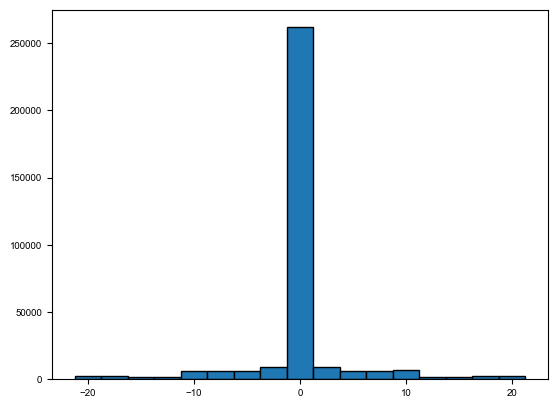

In [32]:
plt.hist(head_velocity.flatten(),bins = np.linspace(-21.25, 21.25, 18),edgecolor='black')

(array([  2047.,   1513.,   1157.,   1246.,   5612.,   4980.,   5336.,
          7622., 275747.,   7600.,   5315.,   4935.,   5525.,   1330.,
          1235.,   1615.,   2185.]),
 array([-21.25, -18.75, -16.25, -13.75, -11.25,  -8.75,  -6.25,  -3.75,
         -1.25,   1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,
         18.75,  21.25]),
 <BarContainer object of 17 artists>)

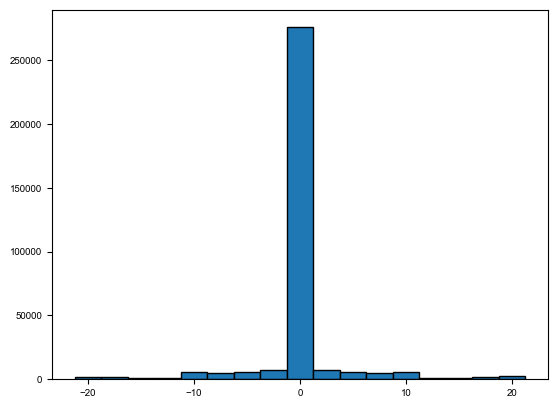

In [33]:
plt.hist(visual_velocity.flatten(),bins = np.linspace(-21.25, 21.25, 18),edgecolor='black')

In [34]:
binv = np.linspace(-21.25, 21.25, 18)

for idx in range(n_trials):
    head_velocity_binned[idx,:]= -20+(np.digitize(head_velocity_binned[idx,:], binv)-1)*2.5
    visual_velocity_binned[idx,:]= -20+(np.digitize(visual_velocity_binned[idx,:], binv)-1)*2.5

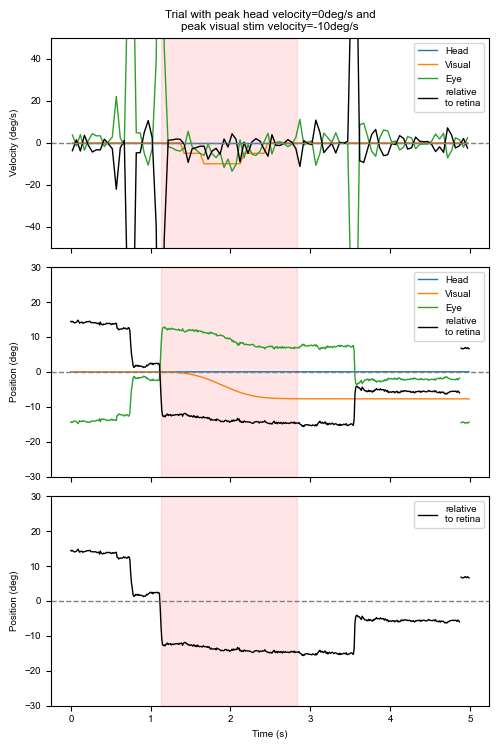

In [35]:
idx_trial=0
#idx_trial=np.where((Trial_Head_Velocity==20)&(Trial_Visual_Velocity==0))[0][0]

nrows,ncols=3,1
fig, axs = plt.subplots(nrows,ncols, figsize=(5*ncols,2.5*nrows), facecolor='w', edgecolor='k',sharex=True)#,sharex=True)
axs = axs.ravel()


axs[0].set_title('Trial with peak head velocity=%ddeg/s and\npeak visual stim velocity=%ddeg/s'%(trial_types[idx_trial,0],trial_types[idx_trial,1]))

# Plot velocities
axs[0].plot(time_binned, head_velocity_binned[idx_trial, :], label="Head")
axs[0].plot(time_binned, visual_velocity_binned[idx_trial, :], label="Visual")
axs[0].plot(time_binned, eye_velocity_binned[idx_trial, :], label="Eye")
axs[0].plot(time_binned, eye_velocity_relretina_binned[idx_trial, :], color="k", label="relative\nto retina")
axs[0].set_ylabel("Velocity (deg/s)")
axs[0].legend(loc='best')
axs[0].set_ylim([-50,50])

# Plot positions
axs[1].plot(time, head_position[idx_trial, :], label="Head")
axs[1].plot(time, visual_position[idx_trial, :], label="Visual")
axs[1].plot(time, eye_position[idx_trial, :], label="Eye")
axs[1].plot(time,position_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[1].set_ylabel("Position (deg)")
axs[1].legend(loc='best')
axs[1].set_ylim([-30,30])


axs[2].plot(time,position_drift_on_retina_vs_time[idx_trial, :], color="k", label="relative\nto retina")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Position (deg)")
axs[2].legend(loc='best')
axs[2].set_ylim([-30,30])

for idx in [0,1,2]:
    axs[idx].axhline(y=0,ls='--',c='grey')
    axs[idx].axvspan(time[idx_movement[0]], time[idx_movement[-1]], color='red', alpha=0.1)


plt.tight_layout()

In [36]:
arremc[0].shape[0]

333

In [37]:
np.unique(head_velocity_binned)[1]

np.float64(-15.0)

In [38]:


# for i in range(arremc[0].shape[0]):
#     countp = 0
#     head_vel_bin_rem = head_velocity_binned[arremc[0][i],20+arremc[1][i]]
#     vis_vel_bin_rem = visual_velocity_binned[arremc[0][i],20+arremc[1][i]]
#     print(f"trial n° {arremc[0][i]}")
#     print("Head velocity binned at rem: ",head_vel_bin_rem)
#     print("Stimulus velocity binned at rem: ",vis_vel_bin_rem)
#     wbin = np.where((head_velocity_binned[:,20:60] == head_vel_bin_rem) & (visual_velocity_binned[:,20:60] == vis_vel_bin_rem))
#     for j in range(len(wbin[0])):
#         # if arremc[0][i] == wbin[0][j]: 
#         #     countp += 1
#         # else:
#             #whar = np.where(arremc[0]==wbin[0][j])
#             #for k in range(len(wbin[1])):
#         if wbin[0][j] in arremc[0]:
#             if head_velocity_binned[wbin[0][j],20+wbin[1][j]] == head_vel_bin_rem and visual_velocity_binned[wbin[0][j],20+wbin[1][j]] == vis_vel_bin_rem:
#                 countp += 1
    
#     print("wbin: ", wbin)
#     print("countp: ", countp)
#     print(f"probability of rem at head_vel = {head_vel_bin_rem} and vis_vel = {vis_vel_bin_rem} is {countp/len(wbin[0])}")
;  

''

In [39]:
mprob = np.zeros((17,17))

for i in range(len(np.unique(head_velocity_binned))):
    for j in range(len(np.unique(visual_velocity_binned))):
        countp = 0
        head_vel_bin_rem = np.unique(head_velocity_binned)[i]
        vis_vel_bin_rem = np.unique(visual_velocity_binned)[j]
        #print(f"trial n° {arremc[0][i]}")
        print("Head velocity binned at rem: ",head_vel_bin_rem)
        print("Stimulus velocity binned at rem: ",vis_vel_bin_rem)
        wbin = np.where((head_velocity_binned[:,20:60] == head_vel_bin_rem) & (visual_velocity_binned[:,20:60] == vis_vel_bin_rem))
        for h in range(len(wbin[0])):
            # if arremc[0][i] == wbin[0][j]: 
            #     countp += 1
            # else:
                #whar = np.where(arremc[0]==wbin[0][j])
                #for k in range(len(wbin[1])):
            whar = np.where(arremc[0]==wbin[0][h])
            #print("whar: ", whar)
            for k in whar[0]:
                if arremc[1][k] == wbin[1][h]:
                    countp += 1
        

        print("wbin: ", wbin)
        print("countp: ", countp)
        if countp >0:
            print(f"probability of rem at head_vel = {head_vel_bin_rem} and vis_vel = {vis_vel_bin_rem} is {countp/len(wbin[0])}")
            mprob[i,j] = countp/len(wbin[0])
        else:
            if len(wbin[0]) == 0 & len(wbin[1]) == 0:
                mprob[i,j] = -0.001
            else:
                mprob[i,j] = 0    

Head velocity binned at rem:  -20.0
Stimulus velocity binned at rem:  -20.0
wbin:  (array([  4,   4,   4,   4,   4,   4,   9,   9,   9,   9,   9,   9,  31,
        31,  31,  31,  31,  31,  44,  44,  44,  44,  44,  44,  51,  51,
        51,  51,  51,  51,  65,  65,  65,  65,  65,  65,  72,  72,  72,
        72,  72,  72,  83,  83,  83,  83,  83,  83,  94,  94,  94,  94,
        94,  94,  99,  99,  99,  99,  99,  99, 119, 119, 119, 119, 119,
       119, 152, 152, 152, 152, 152, 152, 181, 181, 181, 181, 181, 181,
       222, 222, 222, 222, 222, 222, 231, 231, 231, 231, 231, 231, 236,
       236, 236, 236, 236, 236, 249, 249, 249, 249, 249, 249, 288, 288,
       288, 288, 288, 288, 290, 290, 290, 290, 290, 290, 299, 299, 299,
       299, 299, 299, 321, 321, 321, 321, 321, 321, 382, 382, 382, 382,
       382, 382, 398, 398, 398, 398, 398, 398, 403, 403, 403, 403, 403,
       403, 410, 410, 410, 410, 410, 410, 420, 420, 420, 420, 420, 420,
       431, 431, 431, 431, 431, 431, 488, 488, 488, 

In [40]:
len(wbin[0])

228

In [41]:
mprob

array([[ 0.01470588, -0.001     ,  0.01041667, -0.001     ,  0.05263158,
        -0.001     , -0.001     , -0.001     , -0.001     ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.001     ,  0.00490196,  0.03645833,  0.        ,  0.05701754,
        -0.001     , -0.001     , -0.001     , -0.001     ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.00666667,  0.        ,  0.01228501,  0.01098901,  0.01233184,
        -0.001     ,  0.02777778, -0.001     , -0.001     ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.001     ,  0.        ,  0.        ,  0.00561798,  0.01274363,
         0.02077922,  0.05555556, -0.001     , -0.001     ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        

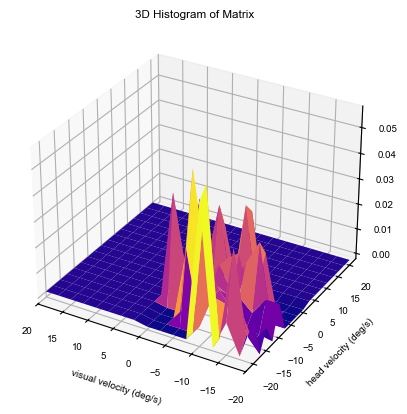

In [42]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

matrix = mprob

rows, cols = matrix.shape
x_vals = np.linspace(-20, 20, cols)
y_vals = np.linspace(-20, 20, rows)
x, y = np.meshgrid(x_vals, y_vals)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, matrix, cmap='plasma')

ax.set_xlim(20, -20)

ax.set_xlabel('visual velocity (deg/s)')
ax.set_ylabel('head velocity (deg/s)')
ax.set_zlabel('probability of rem')
ax.set_title('3D Histogram of Matrix')
plt.show()

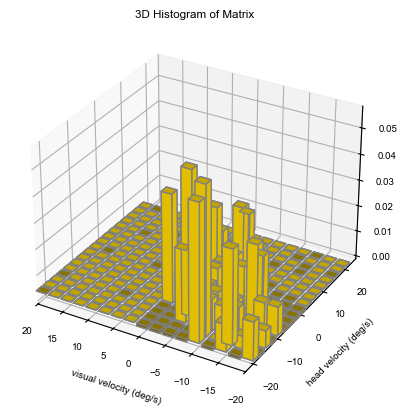

In [43]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(x_vals, y_vals)

# Flatten the grid and values for bar3d
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)  # Bottom of the bars (z=0)
dx = dy = 2       # Width and depth of each bar
dz = matrix.flatten() # Height of bars (the actual values)

ax.bar3d(x, y, z, dx, dy, dz, shade=True, color='gold', edgecolor='gray')

ax.set_xlim(20, -20)

ax.set_xlabel('visual velocity (deg/s)')
ax.set_ylabel('head velocity (deg/s)')
ax.set_zlabel('probability of rem')
ax.set_title('3D Histogram of Matrix')

plt.show()

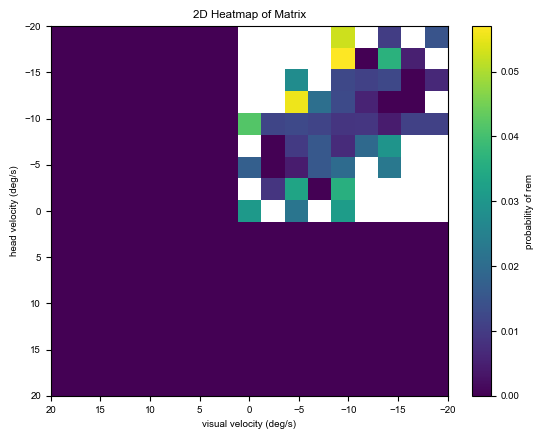

In [44]:
masked_matrix = np.ma.masked_less(matrix, 0)

cmap = plt.cm.viridis 
cmap.set_bad(color='white')

fig, ax = plt.subplots()

im = ax.imshow(masked_matrix, cmap=cmap, aspect='auto',
               extent=[x_vals.min(), x_vals.max(), y_vals.max(), y_vals.min()],
               interpolation='none')

ax.set_xlabel('visual velocity (deg/s)')
ax.set_ylabel('head velocity (deg/s)')
ax.set_title('2D Heatmap of Matrix')


cbar = fig.colorbar(im)
cbar.set_label('probability of rem')


ax.set_xlim(20, -20)

plt.show()

In [45]:
dprob = pd.DataFrame(mprob, index=np.linspace(-20, 20, mprob.shape[0], dtype=float), columns=np.linspace(-20, 20, mprob.shape[0], dtype=float))

dprob

,-20.0,-17.5,-15.0,-12.5,-10.0,-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0
-20.0,0.014706,-0.001000,0.010417,-0.001000,0.052632,-0.001000,-0.001000,-0.001000,-0.001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-17.5,-0.001000,0.004902,0.036458,0.000000,0.057018,-0.001000,-0.001000,-0.001000,-0.001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-15.0,0.006667,0.000000,0.012285,0.010989,0.012332,-0.001000,0.027778,-0.001000,-0.001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-12.5,-0.001000,0.000000,0.000000,0.005618,0.012744,0.020779,0.055556,-0.001000,-0.001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-10.0,0.011111,0.011111,0.004255,0.008969,0.008869,0.011589,0.012563,0.011905,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7.5,-0.001000,-0.001000,0.029412,0.019553,0.007109,0.015769,0.009756,0.000000,-0.001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-5.0,-0.001000,-0.001000,0.022876,-0.001000,0.019883,0.015686,0.004376,0.000000,0.017241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2.5,-0.001000,-0.001000,-0.001000,-0.001000,0.036036,0.000000,0.033333,0.008772,-0.001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,-0.001000,-0.001000,-0.001000,-0.001000,0.031532,-0.001000,0.022222,-0.001000,0.030702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## MLP models (discretized velocities)

### Create features and targets

In [46]:
import numpy as np

def quick_diagnostics(y_train, y_val, X_train, X_val):
    # shapes
    print("X_train:", np.shape(X_train), "X_val:", np.shape(X_val))
    print("y_train:", np.shape(y_train), "y_val:", np.shape(y_val))
    # class balance
    def stats(y, name):
        y = np.asarray(y).astype(int)
        pos = (y==1).sum(); neg = (y==0).sum()
        print(f"{name}: pos={pos}, neg={neg}, pos_rate={pos/(pos+neg+1e-9):.3f}")
    stats(y_train, "train"); stats(y_val, "val")


In [47]:
arremc

[array([  0,   3,   4,   4,   6,   7,  11,  12,  14,  15,  15,  18,  19,
         20,  25,  25,  25,  28,  29,  31,  37,  39,  41,  41,  41,  49,
         54,  55,  55,  55,  60,  60,  60,  63,  65,  77,  78,  78,  87,
         93,  96, 100, 100, 108, 111, 116, 116, 117, 118, 120, 125, 125,
        125, 128, 129, 131, 134, 137, 142, 142, 146, 147, 150, 151, 152,
        154, 154, 163, 164, 167, 173, 178, 179, 182, 183, 183, 185, 185,
        185, 186, 188, 188, 189, 191, 191, 196, 200, 201, 202, 203, 203,
        209, 209, 213, 215, 217, 219, 220, 221, 223, 226, 226, 226, 226,
        227, 228, 233, 233, 238, 243, 243, 248, 251, 251, 254, 255, 256,
        263, 263, 263, 270, 270, 272, 274, 280, 281, 284, 285, 287, 287,
        296, 297, 297, 300, 301, 304, 314, 315, 315, 320, 323, 325, 328,
        328, 330, 332, 332, 335, 335, 336, 337, 340, 341, 341, 342, 343,
        346, 347, 348, 348, 349, 353, 353, 355, 355, 356, 358, 363, 370,
        370, 372, 372, 375, 375, 375, 377, 380, 384

Create features array

In [137]:
velocities = np.random.rand(670,40,2)

In [138]:
for i in range(670):
    for j in range(40):
        velocities[i,j,0] = head_velocity_binned[i,j+20]
        velocities[i,j,1] = visual_velocity_binned[i,j+20]

In [139]:
velocities[:10]

array([[[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0., -10.],
        [  0., -10.],
        [  0., -10.],
        [  0., -10.],
        [  0., -10.],
        [  0., -10.],
        [  0., -10.],
        [  0., -10.],
        [  0., -10.],
        [  0., -10.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0.,  -5.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        

Create target array

In [140]:
targets = np.zeros((n_trials, 40), dtype=int)
targets[arremc[0], arremc[1]] = 1

In [141]:
targets[:10]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Train/Test split 80/20

In [142]:
trial_indices = np.arange(n_trials)
train_trials, test_trials = train_test_split(trial_indices, test_size=0.2, random_state=333)

X_train = velocities[train_trials]
y_train = targets[train_trials]

X_test = velocities[test_trials]
y_test = targets[test_trials]

In [143]:
X_train.shape, y_train.shape

((536, 40, 2), (536, 40))

In [55]:
# Validation split
from sklearn.model_selection import train_test_split

# Split off 20% of the training data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=3,
    #stratify=y_train  # keeps class balance consistent
)

print("Train:", X_tr.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (428, 40, 2) Val: (108, 40, 2) Test: (134, 40, 2)


### Simple MLP ( current bin )

Flatten data

In [56]:
# Flatten
X_train_flat = X_tr.reshape(-1, 2)
y_train_flat = y_tr.reshape(-1)

X_test_flat = X_test.reshape(-1, 2)
y_test_flat = y_test.reshape(-1)

X_val_flat = X_val.reshape(-1, 2)
y_val_flat = y_val.reshape(-1)

In [57]:
X_train_flat.shape, y_train_flat.shape

((17120, 2), (17120,))

In [98]:
X_tr[:10], y_tr[:10]

(array([[  5.,  -5.,   5.,  -5.,   5.,  -5.,   5.,  -5.,   5., -10.,  10.,
         -10.,  10., -10.,  10., -10.,  10., -10.,  10., -10.,  10., -10.,
          10., -10.,  10., -10.,  10., -10.],
        [  0.,   5.,   0.,  10.,   0.,  10.,   0.,  10.,   0.,  15.,   0.,
          15.,   0.,  15.,   0.,  20.,   0.,  20.,   0.,  20.,   0.,  20.,
           0.,  20.,   0.,  20.,   0.,  15.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   5.,   5.,   5.,   5.,   5.,   5.,  10.,  10.,  10.,  10.,
          10.,  10.,  15.,  15.,  15.,  15.],
        [-10.,   0., -10.,   0., -10.,   0., -10.,   0., -10.,   0., -10.,
           0., -10.,   0., -10.,   0., -10.,   0.,  -5.,   0.,  -5.,   0.,
          -5.,   0.,  -5.,   0.,  -5.,   0.],
        [  0., -15.,   0., -15.,   0., -15.,   0., -20.,   0., -20.,   0.,
         -20.,   0., -20.,   0., -20.,   0., -20.,   0., -15.,   0., -15.,
           0., -15.,   0., -10.,   0., -10.],
        [ 10.,  10.,

Hyperparameters search

In [78]:
from hypersearch import search_mlp, summarize_run
import numpy as np
import torch
import json
from pathlib import Path


# If y is imbalanced, pos_weight = N_neg / N_pos (makes positives count more in BCEWithLogits)
def compute_pos_weight(y):
    y = np.asarray(y).astype(int)
    pos = (y==1).sum()
    neg = (y==0).sum()
    return float(neg / max(pos, 1))


pos_weight = compute_pos_weight(y_train_flat)

best_model, best_cfg, best_hist, leaderboard = search_mlp(
    X_train_flat, y_train_flat, X_val_flat, y_val_flat,
    n_trials=40,                    # bump up/down as you like
    class_pos_weight=pos_weight,    # handles imbalance in loss
    seed=42
)

print(summarize_run(best_hist, best_cfg))

# Save artifacts (optional)
import pandas as pd, time
lb_df = pd.DataFrame(leaderboard)
ts = int(time.time())
lb_path = Path.cwd() / f"results/mlp_leaderboard_{ts}.csv"
lb_df.to_csv(lb_path, index=False)

torch.save(best_model.state_dict(), Path.cwd() / f"results/mlp_best_state_{ts}.pt")

# Show where to find them
print("Saved leaderboard to:", lb_path)

Best trial (by val_f1):
  trial: 7
  batch_size: 128
  hidden: [256, 128]
  dropout: 0.0624
  lr: 0.0023032553952781233
  weight_decay: 2.4774296595168384e-08
  max_epochs: 60
  patience: 10
  val_f1: 0.04018912529550828
  val_roc_auc: 0.5950167001944773
  final_val_loss: 1.2996632946862114

Learning curves (last 5 epochs):
  train_loss: 1.3319, 1.3240, 1.3188, 1.3200, 1.3237
  val_loss: 1.3002, 1.3163, 1.2903, 1.3190, 1.2997
  train_f1: 0.0374, 0.0396, 0.0403, 0.0405, 0.0387
  val_f1: 0.0340, 0.0277, 0.0361, 0.0302, 0.0331
  val_roc_auc: 0.5869, 0.5764, 0.6065, 0.5885, 0.5950
  val_acc: 0.7238, 0.7565, 0.7530, 0.6132, 0.7160
Saved leaderboard to: /Users/alessandrobottardi/Desktop/bocconi/tesi/Alessandro_Bottardi/results/mlp_leaderboard_1757519301.csv


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from hypersearch import MLP

X_final = np.concatenate([X_tr, X_val], axis=0)
y_final = np.concatenate([y_tr, y_val], axis=0)

X_final_flat = X_final.reshape(-1, 2)
y_final_flat = y_final.reshape(-1)

train_ds = TensorDataset(torch.tensor(X_final_flat, dtype=torch.float32),
                         torch.tensor(y_final_flat, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)

if torch.backends.mps.is_available():
    DEVICE = "mps"   
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print("shape:", X_final_flat.shape[1])

input_dim = X_final_flat.shape[1]  
model = MLP(input_dim=input_dim, hidden_sizes=[256, 128], dropout=0.4633, bn=True).to(DEVICE)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=0.0023032553952781233,
                        weight_decay=2.4774296595168384e-08)

max_epochs = 60
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    running_loss /= len(train_loader.dataset)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {running_loss:.4f}")

shape: 2
Epoch 1/60, Loss: 0.1043
Epoch 10/60, Loss: 0.0671
Epoch 20/60, Loss: 0.0663
Epoch 30/60, Loss: 0.0654
Epoch 40/60, Loss: 0.0659
Epoch 50/60, Loss: 0.0649
Epoch 60/60, Loss: 0.0648


In [80]:
from sklearn.metrics import roc_auc_score

model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test_flat, dtype=torch.float32).to(DEVICE))
    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= 0.5).astype(int)

print(classification_report(y_test_flat, preds, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test_flat, probs))

              precision    recall  f1-score   support

           0      0.986     1.000     0.993      5283
           1      0.000     0.000     0.000        77

    accuracy                          0.986      5360
   macro avg      0.493     0.500     0.496      5360
weighted avg      0.971     0.986     0.979      5360

Test ROC-AUC: 0.5896074396926185


/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### Undersampling with RandomUnderSampler

In [85]:
ros = RandomUnderSampler(random_state=34)
X_resampled, y_resampled = ros.fit_resample(X_train_flat, y_train_flat)

Hyperparameters search

In [82]:
pos_weight_u = compute_pos_weight(y_resampled)

best_model_u, best_cfg_u, best_hist_u, leaderboard_u = search_mlp(
    X_resampled, y_resampled, X_val_flat, y_val_flat,
    n_trials=100,                    
    class_pos_weight=pos_weight_u,    
    seed=36
)

print(summarize_run(best_hist_u, best_cfg_u))

Best trial (by val_f1):
  trial: 85
  batch_size: 256
  hidden: [128, 64]
  dropout: 0.4274
  lr: 0.0010949184270952243
  weight_decay: 5.551432924431411e-07
  max_epochs: 40
  patience: 6
  val_f1: 0.042735042735042736
  val_roc_auc: 0.6172501779920585
  final_val_loss: 0.6939890618677492

Learning curves (last 5 epochs):
  train_loss: 0.6903, 0.6740, 0.6970, 0.6847, 0.6834
  val_loss: 0.6746, 0.6858, 0.6914, 0.6936, 0.6940
  train_f1: 0.5070, 0.5043, 0.5042, 0.5232, 0.5140
  val_f1: 0.0346, 0.0319, 0.0321, 0.0321, 0.0321
  val_roc_auc: 0.6256, 0.6239, 0.6202, 0.6191, 0.6173
  val_acc: 0.7160, 0.6484, 0.6229, 0.6229, 0.6229


In [86]:

X_final_flat_2, y_final_flat_2 = ros.fit_resample(X_final_flat, y_final_flat)

train_ds_2 = TensorDataset(torch.tensor(X_final_flat_2, dtype=torch.float32),
                         torch.tensor(y_final_flat_2, dtype=torch.long))
train_loader_2 = DataLoader(train_ds_2, batch_size=256, shuffle=True)


input_dim_2 = X_final_flat_2.shape[1]  

model2 = MLP(input_dim=input_dim_2, hidden_sizes=[128, 64], dropout=0.4274, bn=True).to(DEVICE)

optimizer2 = optim.AdamW(model2.parameters(),
                        lr=0.0010949184270952243,
                        weight_decay=5.551432924431411e-07)

max_epochs = 40
for epoch in range(max_epochs):
    model2.train()
    running_loss2 = 0.0
    for xb, yb in train_loader_2:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer2.zero_grad()
        logits2 = model2(xb)
        loss2 = criterion(logits2, yb.float())
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item() * xb.size(0)

    running_loss2 /= len(train_loader_2.dataset)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {running_loss2:.4f}")

Epoch 1/40, Loss: 0.8321
Epoch 10/40, Loss: 0.6818
Epoch 20/40, Loss: 0.6599
Epoch 30/40, Loss: 0.6659
Epoch 40/40, Loss: 0.6510


In [87]:
from sklearn.metrics import roc_auc_score

model2.eval()
with torch.no_grad():
    logits2 = model2(torch.tensor(X_test_flat, dtype=torch.float32).to(DEVICE))
    probs2 = torch.sigmoid(logits2).cpu().numpy()
    preds2 = (probs2 >= 0.5).astype(int)

print(classification_report(y_test_flat, preds2, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test_flat, probs2))

              precision    recall  f1-score   support

           0      0.989     0.674     0.802      5283
           1      0.020     0.468     0.039        77

    accuracy                          0.671      5360
   macro avg      0.505     0.571     0.420      5360
weighted avg      0.975     0.671     0.791      5360

Test ROC-AUC: 0.6139688439518083


### 3D data MLP

In [111]:
# Validation split
from sklearn.model_selection import train_test_split

# Split off 20% of the training data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=88,
    stratify=y_train.mean(axis=1) > 0  # keeps class balance consistent
)

print("Train:", X_tr.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (428, 40, 2) Val: (108, 40, 2) Test: (134, 40, 2)


In [119]:
from hypersearch import TimeStepMLPToken, search_timestep_mlp_token, TimeSeriesTransformerToken, search_transformer_token, TimeSeriesTransformerToken, summarize_run

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# ---- Split by TRIAL (keep sequence integrity). X: [N_trials, T, F], y: [N_trials, T] ----
# N_trials = X_train.shape[0]
# rng = np.random.RandomState(42)
# idx = np.arange(N_trials)
# tr_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y_train.mean(axis=1) > 0)  # stratify on REM presence

# X_tr, y_tr   = X_train[tr_idx], y_train[tr_idx]
# X_val, y_val = X_train[val_idx], y_train[val_idx]

# Optional: class imbalance weight on tokens
yt = y_tr.reshape(-1).astype(int)
pos_weight = float((yt == 0).sum() / max((yt == 1).sum(), 1))

# ============================
# 1) Search: per-time-step MLP
# ============================
best_model, best_cfg, best_hist, leaderboard = search_timestep_mlp_token(
    X_tr, y_tr, X_val, y_val,
    n_trials=40,
    class_pos_weight=pos_weight,
    seed=22
)
print(summarize_run(best_hist, best_cfg))

# Refit best on (train+val)
batch_size = int(best_cfg["batch_size"])
hidden     = best_cfg["hidden"]
dropout    = float(best_cfg["dropout"])
lr         = float(best_cfg["lr"])
wd         = float(best_cfg["weight_decay"])
max_epochs = int(best_cfg["max_epochs"])

X_final, y_final = np.concatenate([X_tr, X_val], axis=0), np.concatenate([y_tr, y_val], axis=0)

train_ds = TensorDataset(torch.tensor(X_final, dtype=torch.float32),
                         torch.tensor(y_final, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

feature_dim = X_final.shape[-1]
model = TimeStepMLPToken(feature_dim=feature_dim, hidden_sizes=hidden, dropout=dropout, bn=True).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(max_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)         # xb: [B,T,F], yb: [B,T]
        optimizer.zero_grad()
        logits = model(xb)                             # [B,T]
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
    if epoch == 0 or (epoch+1) % 10 == 0:
        print(f"[Refit-MLP] Epoch {epoch+1}/{max_epochs}")

# Evaluate on test
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, drop_last=False)

model.eval()
all_probs, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)                              # [B,T]
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_true.append(yb.numpy())
all_probs = np.concatenate(all_probs, axis=0)
all_true  = np.concatenate(all_true,  axis=0)

preds = (all_probs >= 0.5).astype(int).reshape(-1)
yt    = all_true.reshape(-1)
print("MLP-token | classification report:\n", classification_report(yt, preds, digits=3))
try:
    print("MLP-token | Test AUC:", roc_auc_score(yt, all_probs.reshape(-1)))
except Exception:
    print("MLP-token | Test AUC: nan")

Best trial (by val_f1):
  trial: 26
  batch_size: 128
  hidden: [256, 128, 64]
  dropout: 0.4232
  lr: 0.00022112692396273093
  weight_decay: 4.706878335642531e-06
  max_epochs: 40
  patience: 8
  val_f1: 0.04081632653061224
  val_roc_auc: 0.5759648905240241
  final_val_loss: 1.3463146686553955

Learning curves (last 5 epochs):
  train_loss: 1.3576, 1.3649, 1.3742, 1.3608, 1.3745
  val_loss: 1.3528, 1.3494, 1.3475, 1.3466, 1.3463
  train_f1: 0.0303, 0.0286, 0.0296, 0.0290, 0.0294
  val_f1: 0.0297, 0.0294, 0.0313, 0.0287, 0.0287
  val_roc_auc: 0.5752, 0.5781, 0.5811, 0.5793, 0.5760
  val_acc: 0.6829, 0.6484, 0.6280, 0.6391, 0.6391
[Refit-MLP] Epoch 1/40
[Refit-MLP] Epoch 10/40
[Refit-MLP] Epoch 20/40
[Refit-MLP] Epoch 30/40
[Refit-MLP] Epoch 40/40
MLP-token | classification report:
               precision    recall  f1-score   support

           0      0.986     1.000     0.993      5283
           1      0.000     0.000     0.000        77

    accuracy                          0.986

/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### MLP with context 1

In [95]:
# Sliding-window MLP with automatic window-size search 
def make_context_windows(X, y, window_size: int):
    """
    X: [n_trials, n_bins, n_features]
    y: [n_trials, n_bins] or [n_trials, n_bins, 1]
    Returns:
        Xw: [N_eff, (window_size+1)*n_features]
        yw: [N_eff] (0/1)
    """
    y = np.asarray(y)
    if y.ndim == 3 and y.shape[-1] == 1:
        y = y[..., 0]
    n_trials, n_bins, n_features = X.shape
    X_out, y_out = [], []
    for tr in range(n_trials):
        for b in range(window_size, n_bins):
            window = X[tr, b-window_size:b+1]       # [W+1, F]
            X_out.append(window.reshape(-1))        # [(W+1)*F]
            y_out.append(y[tr, b])                  # label at current bin
    return np.asarray(X_out), np.asarray(y_out).astype(int)


# 2) Choose the window sizes to try
WINDOW_SIZES = [2,3,4,5,6,7,8,9,10,13,15]  # add/remove values as you wish

window_results = []   # will store dicts with {window, best_cfg, val_f1, val_auc, ...}

# 3) Loop over window sizes and run hyperparameter search
for W in WINDOW_SIZES:
    print(f"\n=== Window size: {W} ===")
    X_train_w, y_train_w = make_context_windows(X_train, y_train, W)
    X_test_w,  y_test_w  = make_context_windows(X_test,  y_test,  W)

    # Train/Val split for search
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_w, y_train_w, test_size=0.2, random_state=42, stratify=y_train_w
    )

    pos_weight = compute_pos_weight(y_tr)

    best_model, best_cfg, best_hist, leaderboard = search_mlp(
        X_tr, y_tr, X_val, y_val,
        n_trials=40,                 # increase if needed
        class_pos_weight=pos_weight,
        seed=77
    )

    print(summarize_run(best_hist, best_cfg))
    window_results.append({
        "window": W,
        "best_cfg": best_cfg,
        "val_f1": best_cfg["val_f1"],
        "val_roc_auc": best_cfg["val_roc_auc"],
    })

# 4) Pick the best window by validation F1
window_results = sorted(window_results, key=lambda d: (-d["val_f1"], - (d["val_roc_auc"] if d["val_roc_auc"]==d["val_roc_auc"] else -1)))
best_window = window_results[0]["window"]
best_cfg = window_results[0]["best_cfg"]
print("\n=== BEST WINDOW SELECTED ===")
print(f"Window = {best_window}\nConfig = {best_cfg}")

# 5) Rebuild data for the best window, refit on Train+Val, evaluate on Test
X_train_w, y_train_w = make_context_windows(X_train, y_train, best_window)
X_test_w,  y_test_w  = make_context_windows(X_test,  y_test,  best_window)

# Split again to tune decision threshold on val (kept small and internal)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_w, y_train_w, test_size=0.2, random_state=66, stratify=y_train_w
)

# (a) Refit on Train+Val (fixed epochs from best_cfg)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_final = np.concatenate([X_tr, X_val], axis=0)
y_final = np.concatenate([y_tr, y_val], axis=0)

train_ds = TensorDataset(torch.tensor(X_final, dtype=torch.float32),
                         torch.tensor(y_final, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=int(best_cfg["batch_size"]), shuffle=True)

model = MLP(
    input_dim=X_final.shape[1],
    hidden_sizes=best_cfg["hidden"],
    dropout=float(best_cfg["dropout"]),
    bn=True
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=float(best_cfg["lr"]),
                        weight_decay=float(best_cfg["weight_decay"]))

max_epochs = int(best_cfg["max_epochs"])
for epoch in range(max_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"[Refit] Epoch {epoch+1}/{max_epochs}")

# (b) Tune decision threshold on the validation portion ONLY (for F1)
model.eval()
with torch.no_grad():
    logits_val = model(torch.tensor(X_val, dtype=torch.float32).to(DEVICE))
    probs_val = torch.sigmoid(logits_val).cpu().numpy()

best_thresh, best_f1 = 0.5, -1
for t in np.linspace(0.1, 0.9, 17):  # 0.1 .. 0.9 step 0.05
    preds_val = (probs_val >= t).astype(int)
    f1 = f1_score(y_val, preds_val)
    if f1 > best_f1:
        best_f1, best_thresh = f1, t
print(f"Chosen threshold on val: {best_thresh:.2f} (F1={best_f1:.4f})")

# (c) Final evaluation on test (untouched)
with torch.no_grad():
    logits_test = model(torch.tensor(X_test_w, dtype=torch.float32).to(DEVICE))
    probs_test  = torch.sigmoid(logits_test).cpu().numpy()
preds_test = (probs_test >= best_thresh).astype(int)

print("\n=== TEST RESULTS (window =", best_window, ") ===")
print("Accuracy:",  accuracy_score(y_test_w, preds_test))
print("F1:",        f1_score(y_test_w, preds_test))
try:
    print("ROC-AUC:", roc_auc_score(y_test_w, probs_test))
except Exception:
    print("ROC-AUC: nan")


=== Window size: 2 ===
Best trial (by val_f1):
  trial: 15
  batch_size: 64
  hidden: [128]
  dropout: 0.0441
  lr: 0.002319334870951176
  weight_decay: 3.6921437762946624e-08
  max_epochs: 60
  patience: 8
  val_f1: 0.059508408796895215
  val_roc_auc: 0.6853006958250497
  final_val_loss: 1.2548818439610987

Learning curves (last 5 epochs):
  train_loss: 1.3237, 1.3172, 1.3220, 1.3164, 1.3011
  val_loss: 1.2551, 1.2683, 1.2920, 1.3176, 1.2549
  train_f1: 0.0372, 0.0406, 0.0374, 0.0397, 0.0402
  val_f1: 0.0539, 0.0412, 0.0357, 0.0353, 0.0471
  val_roc_auc: 0.6896, 0.6775, 0.6554, 0.6388, 0.6853
  val_acc: 0.7759, 0.6232, 0.5756, 0.5574, 0.7121

=== Window size: 3 ===
Best trial (by val_f1):
  trial: 12
  batch_size: 128
  hidden: [256, 128]
  dropout: 0.4526
  lr: 0.0010391146858858928
  weight_decay: 1.90449898060022e-08
  max_epochs: 60
  patience: 10
  val_f1: 0.056485355648535567
  val_roc_auc: 0.6789725078392765
  final_val_loss: 1.2683234081660166

Learning curves (last 5 epochs)

In [96]:
# 5) Rebuild data for the best window, refit on Train+Val, evaluate on Test
X_train_w, y_train_w = make_context_windows(X_train, y_train, best_window)
X_test_w,  y_test_w  = make_context_windows(X_test,  y_test,  best_window)

# Split again to tune decision threshold on val (kept small and internal)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_w, y_train_w, test_size=0.2, random_state=66, stratify=y_train_w
)

# (a) Refit on Train+Val (fixed epochs from best_cfg)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_final = np.concatenate([X_tr, X_val], axis=0)
y_final = np.concatenate([y_tr, y_val], axis=0)

train_ds = TensorDataset(torch.tensor(X_final, dtype=torch.float32),
                         torch.tensor(y_final, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=int(best_cfg["batch_size"]), shuffle=True)

model = MLP(
    input_dim=X_final.shape[1],
    hidden_sizes=best_cfg["hidden"],
    dropout=float(best_cfg["dropout"]),
    bn=True
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=float(best_cfg["lr"]),
                        weight_decay=float(best_cfg["weight_decay"]))

max_epochs = int(best_cfg["max_epochs"])
for epoch in range(max_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"[Refit] Epoch {epoch+1}/{max_epochs}")

# (b) Tune decision threshold on the validation portion ONLY (for F1)
model.eval()
with torch.no_grad():
    logits_val = model(torch.tensor(X_val, dtype=torch.float32).to(DEVICE))
    probs_val = torch.sigmoid(logits_val).cpu().numpy()

best_thresh = 0.5
#best_f1 = -1
# for t in np.linspace(0.1, 0.9, 17):  # 0.1 .. 0.9 step 0.05
#     preds_val = (probs_val >= t).astype(int)
#     f1 = f1_score(y_val, preds_val)
#     if f1 > best_f1:
#         best_f1, best_thresh = f1, t
# print(f"Chosen threshold on val: {best_thresh:.2f} (F1={best_f1:.4f})")

# (c) Final evaluation on test (untouched)
with torch.no_grad():
    logits_test = model(torch.tensor(X_test_w, dtype=torch.float32).to(DEVICE))
    probs_test  = torch.sigmoid(logits_test).cpu().numpy()
preds_test = (probs_test >= best_thresh).astype(int)

print("\n=== TEST RESULTS (window =", best_window, ") ===")
print(classification_report(y_test_w, preds_test, digits=3))
try:
    print("ROC-AUC:", roc_auc_score(y_test_w, probs_test))
except Exception:
    print("ROC-AUC: nan")

[Refit] Epoch 1/40
[Refit] Epoch 10/40
[Refit] Epoch 20/40
[Refit] Epoch 30/40
[Refit] Epoch 40/40

=== TEST RESULTS (window = 13 ) ===
              precision    recall  f1-score   support

           0      0.982     1.000     0.991      3554
           1      0.000     0.000     0.000        64

    accuracy                          0.982      3618
   macro avg      0.491     0.500     0.496      3618
weighted avg      0.965     0.982     0.974      3618

ROC-AUC: 0.6143100203995498


/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### MLP with context 2

In [46]:
def dataset_preceding_data(X, y, window_size=5):
    n_trials, n_bins, n_features = X.shape
    X_out = []
    y_out = []

    for trial in range(n_trials):
        for b in range(window_size,n_bins):
            features = X[trial, b-window_size:b+1].flatten()  # shape: (window+1)*2
            X_out.append(features)
            y_out.append(y[trial, b])
    
    return np.array(X_out), np.array(y_out)

In [47]:
window_size = 5
X_train_prec, y_train_prec = dataset_preceding_data(X_train, y_train, window_size)
X_test_prec, y_test_prec = dataset_preceding_data(X_test, y_test, window_size)

In [48]:
mlp_prec = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128, 64, 32, 16, 8),  # More layers and neurons
    activation='relu',
    solver='adam',
    max_iter=200,               # More epochs (iterations)
    random_state=3,
    early_stopping=False,        # Stop if validation score doesn't improve
    n_iter_no_change=50,        # How many epochs to wait before stopping
    verbose = 2,                # How many epochs to wait before stopping
    alpha=0.03,
    validation_fraction=0.1     # Use 10% of training data as validation
)

In [49]:
mlp_prec.fit(X_train_prec, y_train_prec)

y_pred_prec = mlp_prec.predict(X_test_prec)
print(classification_report(y_test_prec, y_pred_prec, digits=3))

Iteration 1, loss = 0.24334119
Iteration 2, loss = 0.11154789
Iteration 3, loss = 0.10394924
Iteration 4, loss = 0.09662758
Iteration 5, loss = 0.09238392
Iteration 6, loss = 0.09047117
Iteration 7, loss = 0.08712329
Iteration 8, loss = 0.08745459
Iteration 9, loss = 0.08345917
Iteration 10, loss = 0.08257039
Iteration 11, loss = 0.08201653
Iteration 12, loss = 0.08004767
Iteration 13, loss = 0.08059145
Iteration 14, loss = 0.07853869
Iteration 15, loss = 0.07939005
Iteration 16, loss = 0.07824105
Iteration 17, loss = 0.07747932
Iteration 18, loss = 0.07668387
Iteration 19, loss = 0.07688336
Iteration 20, loss = 0.07660494
Iteration 21, loss = 0.07568657
Iteration 22, loss = 0.07681889
Iteration 23, loss = 0.07606570
Iteration 24, loss = 0.07500285
Iteration 25, loss = 0.07518381
Iteration 26, loss = 0.07463043
Iteration 27, loss = 0.07408946
Iteration 28, loss = 0.07445154
Iteration 29, loss = 0.07364060
Iteration 30, loss = 0.07427619
Iteration 31, loss = 0.07450733
Iteration 32, los

/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

## MLP models (only binned data)

### Prepare data

In [19]:
bin = 100
head_velocity2=np.zeros((670,bin))
visual_velocity2=np.zeros((670,bin))

for idx in range(n_trials):
    head_velocity2[idx,:]= head_velocity[idx,:].reshape(bin, 500//bin).mean(axis=1)
    visual_velocity2[idx,:]= visual_velocity[idx,:].reshape(bin, 500//bin).mean(axis=1)


In [20]:
velocities2 = np.random.rand(670,40,2)
for i in range(670):
    for j in range(40):
        velocities2[i,j,0] = head_velocity2[i,j+20]
        velocities2[i,j,1] = visual_velocity2[i,j+20]

# Create target array
targets2 = np.zeros((n_trials, 40), dtype=int)
targets2[arremc[0], arremc[1]] = 1


In [21]:
velocities2[:10], targets2[:10]

(array([[[ 6.24789103e-02, -8.35253238e-03],
         [ 4.71084633e-02, -1.76693410e-02],
         [-2.05581929e-03, -8.48972716e-02],
         [-7.65923704e-02, -3.29345415e-01],
         [-3.61440748e-02, -6.53082450e-01],
         [-2.47423726e-03, -1.08933659e+00],
         [ 8.03458662e-02, -1.64637167e+00],
         [-3.16752179e-03, -2.25700035e+00],
         [ 9.75394174e-02, -2.97751390e+00],
         [ 4.03440259e-02, -3.79713857e+00],
         [ 2.36445965e-02, -4.70822398e+00],
         [ 1.99019095e-02, -5.67306204e+00],
         [ 1.34858485e-02, -6.65234000e+00],
         [ 1.60349873e-02, -7.58975404e+00],
         [ 2.45327240e-02, -8.46064562e+00],
         [-6.66746255e-05, -9.16241210e+00],
         [ 4.92044527e-02, -9.66579542e+00],
         [ 1.49287829e-02, -9.94928032e+00],
         [-1.33780588e-02, -9.97364508e+00],
         [-1.59167562e-02, -9.75175144e+00],
         [-1.90113168e-02, -9.28634761e+00],
         [ 1.76592504e-02, -8.60735809e+00],
         [

In [22]:
train_trials, test_trials = train_test_split(trial_indices, test_size=0.2, random_state=30)

X_train2 = velocities2[train_trials]
y_train2 = targets2[train_trials]

X_test2 = velocities2[test_trials]
y_test2 = targets2[test_trials]

NameError: name 'trial_indices' is not defined

In [ ]:
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train2, y_train2,
    test_size=0.2,
    random_state=77,
    #stratify=y_train  # keeps class balance consistent
)

print("Train:", X_tr2.shape, "Val:", X_val2.shape, "Test:", X_test2.shape)

Train: (428, 40, 2) Val: (108, 40, 2) Test: (134, 40, 2)


### Simple MLP ( current bin )

Flatten data

In [168]:
# Flatten
X_train_flat2 = X_tr2.reshape(-1, 2)
y_train_flat2 = y_tr2.reshape(-1)

X_test_flat2 = X_test2.reshape(-1, 2)
y_test_flat2 = y_test2.reshape(-1)

X_val_flat2 = X_val2.reshape(-1, 2)
y_val_flat2 = y_val2.reshape(-1)

In [169]:
X_train_flat2.shape, y_train_flat2.shape

((17120, 2), (17120,))

Hyperparameters search

In [160]:
pos_weight = compute_pos_weight(y_train_flat2)

best_model, best_cfg, best_hist, leaderboard = search_mlp(
    X_train_flat2, y_train_flat2, X_val_flat2, y_val_flat2,
    n_trials=100,                    # bump up/down as you like
    class_pos_weight=pos_weight,    # handles imbalance in loss
    seed=42
)

print(summarize_run(best_hist, best_cfg))

# Save artifacts (optional)
# import pandas as pd, time
# lb_df = pd.DataFrame(leaderboard)
# ts = int(time.time())
# lb_path = Path.cwd() / f"results/mlp_leaderboard_{ts}.csv"
# lb_df.to_csv(lb_path, index=False)

# torch.save(best_model.state_dict(), Path.cwd() / f"results/mlp_best_state_{ts}.pt")

# # Show where to find them
# print("Saved leaderboard to:", lb_path)

Best trial (by val_f1):
  trial: 91
  batch_size: 64
  hidden: [256, 128, 64]
  dropout: 0.0343
  lr: 0.0025943401132760926
  weight_decay: 1.589611011498183e-08
  max_epochs: 40
  patience: 6
  val_f1: 0.06174957118353345
  val_roc_auc: 0.6155563186813187
  final_val_loss: 1.3451893073541146

Learning curves (last 5 epochs):
  train_loss: 1.3105, 1.3130, 1.3157, 1.3084, 1.3130
  val_loss: 1.3332, 1.3387, 1.3436, 1.3396, 1.3452
  train_f1: 0.0399, 0.0395, 0.0421, 0.0365, 0.0432
  val_f1: 0.0430, 0.0448, 0.0442, 0.0443, 0.0413
  val_roc_auc: 0.6204, 0.6208, 0.6257, 0.6141, 0.6156
  val_acc: 0.7113, 0.7431, 0.7097, 0.7505, 0.6773


In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from hypersearch import MLP

X_final = np.concatenate([X_tr2, X_val2], axis=0)
y_final = np.concatenate([y_tr2, y_val2], axis=0)

X_final_flat = X_final.reshape(-1, 2)
y_final_flat = y_final.reshape(-1)

train_ds = TensorDataset(torch.tensor(X_final_flat, dtype=torch.float32),
                         torch.tensor(y_final_flat, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


input_dim = X_final_flat.shape[1]  
model = MLP(input_dim=input_dim, hidden_sizes=[256, 128, 64], dropout=0.0343, bn=True).to(DEVICE)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=0.0025943401132760926,
                        weight_decay=1.589611011498183e-08)

max_epochs = 40
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    running_loss /= len(train_loader.dataset)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {running_loss:.4f}")

Epoch 1/40, Loss: 0.1067
Epoch 10/40, Loss: 0.0684
Epoch 20/40, Loss: 0.0681
Epoch 30/40, Loss: 0.0676
Epoch 40/40, Loss: 0.0677


In [171]:


model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test_flat2, dtype=torch.float32).to(DEVICE))
    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= 0.5).astype(int)

print(classification_report(y_test_flat2, preds, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test_flat2, probs))

              precision    recall  f1-score   support

           0      0.990     1.000     0.995      5304
           1      0.000     0.000     0.000        56

    accuracy                          0.990      5360
   macro avg      0.495     0.500     0.497      5360
weighted avg      0.979     0.990     0.984      5360

Test ROC-AUC: 0.5702199148890326


/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### Undersampling with RandomUnderSampler

In [166]:
ros = RandomUnderSampler(random_state=36)
X_resampled2, y_resampled2 = ros.fit_resample(X_train_flat2, y_train_flat2)

Hyperparameters search

In [167]:
pos_weight_u = compute_pos_weight(y_resampled2)

best_model_u, best_cfg_u, best_hist_u, leaderboard_u = search_mlp(
    X_resampled2, y_resampled2, X_val_flat2, y_val_flat2,
    n_trials=100,
    class_pos_weight=pos_weight_u,
    seed=36
)

print(summarize_run(best_hist_u, best_cfg_u))

Best trial (by val_f1):
  trial: 49
  batch_size: 64
  hidden: [256, 128]
  dropout: 0.3017
  lr: 0.00014736383905603975
  weight_decay: 6.369310055083967e-08
  max_epochs: 60
  patience: 10
  val_f1: 0.056009334889148193
  val_roc_auc: 0.6381583355668722
  final_val_loss: 0.6082229066778112

Learning curves (last 5 epochs):
  train_loss: 0.6731, 0.6644, 0.6594, 0.6589, 0.6489
  val_loss: 0.5858, 0.6012, 0.6067, 0.6017, 0.6082
  train_f1: 0.4781, 0.4655, 0.5085, 0.4800, 0.5112
  val_f1: 0.0499, 0.0475, 0.0476, 0.0470, 0.0483
  val_roc_auc: 0.6335, 0.6338, 0.6346, 0.6363, 0.6382
  val_acc: 0.7794, 0.7681, 0.7685, 0.7745, 0.7720


In [172]:
X_final_flat_2, y_final_flat_2 = ros.fit_resample(X_final_flat, y_final_flat)

train_ds_2 = TensorDataset(torch.tensor(X_final_flat_2, dtype=torch.float32),
                         torch.tensor(y_final_flat_2, dtype=torch.long))
train_loader_2 = DataLoader(train_ds_2, batch_size=64, shuffle=True)


input_dim_2 = X_final_flat_2.shape[1]  

model2 = MLP(input_dim=input_dim_2, hidden_sizes=[256, 128], dropout=0.3017, bn=True).to(DEVICE)

optimizer2 = optim.AdamW(model2.parameters(),
                        lr=0.00014736383905603975,
                        weight_decay=6.369310055083967e-08)

max_epochs = 60
for epoch in range(max_epochs):
    model2.train()
    running_loss2 = 0.0
    for xb, yb in train_loader_2:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer2.zero_grad()
        logits2 = model2(xb)
        loss2 = criterion(logits2, yb.float())
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item() * xb.size(0)

    running_loss2 /= len(train_loader_2.dataset)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {running_loss2:.4f}")

Epoch 1/60, Loss: 0.6948
Epoch 10/60, Loss: 0.6730
Epoch 20/60, Loss: 0.6728
Epoch 30/60, Loss: 0.6653
Epoch 40/60, Loss: 0.6552
Epoch 50/60, Loss: 0.6668
Epoch 60/60, Loss: 0.6591


In [173]:
from sklearn.metrics import roc_auc_score

model2.eval()
with torch.no_grad():
    logits2 = model2(torch.tensor(X_test_flat2, dtype=torch.float32).to(DEVICE))
    probs2 = torch.sigmoid(logits2).cpu().numpy()
    preds2 = (probs2 >= 0.5).astype(int)

print(classification_report(y_test_flat2, preds2, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test_flat2, probs2))

              precision    recall  f1-score   support

           0      0.991     0.694     0.817      5304
           1      0.014     0.411     0.027        56

    accuracy                          0.691      5360
   macro avg      0.503     0.553     0.422      5360
weighted avg      0.981     0.691     0.808      5360

Test ROC-AUC: 0.5866360967463908


### 3D data MLP

In [146]:
from hypersearch import TimeStepMLPToken, search_timestep_mlp_token, TimeSeriesTransformerToken, search_transformer_token, TimeSeriesTransformerToken, summarize_run

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# ---- Split by TRIAL (keep sequence integrity). X: [N_trials, T, F], y: [N_trials, T] ----
# N_trials = X_train.shape[0]
# rng = np.random.RandomState(42)
# idx = np.arange(N_trials)
# tr_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y_train.mean(axis=1) > 0)  # stratify on REM presence

# X_tr, y_tr   = X_train[tr_idx], y_train[tr_idx]
# X_val, y_val = X_train[val_idx], y_train[val_idx]

# Optional: class imbalance weight on tokens
yt = y_tr2.reshape(-1).astype(int)
pos_weight = float((yt == 0).sum() / max((yt == 1).sum(), 1))

# ============================
# 1) Search: per-time-step MLP
# ============================
best_model, best_cfg, best_hist, leaderboard = search_timestep_mlp_token(
    X_tr2, y_tr2, X_val2, y_val2,
    n_trials=40,
    class_pos_weight=pos_weight,
    seed=22
)
print(summarize_run(best_hist, best_cfg))

# Refit best on (train+val)
batch_size = int(best_cfg["batch_size"])
hidden     = best_cfg["hidden"]
dropout    = float(best_cfg["dropout"])
lr         = float(best_cfg["lr"])
wd         = float(best_cfg["weight_decay"])
max_epochs = int(best_cfg["max_epochs"])

X_final, y_final = np.concatenate([X_tr2, X_val2], axis=0), np.concatenate([y_tr2, y_val2], axis=0)

train_ds = TensorDataset(torch.tensor(X_final, dtype=torch.float32),
                         torch.tensor(y_final, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

feature_dim = X_final.shape[-1]
model = TimeStepMLPToken(feature_dim=feature_dim, hidden_sizes=hidden, dropout=dropout, bn=True).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(max_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)         # xb: [B,T,F], yb: [B,T]
        optimizer.zero_grad()
        logits = model(xb)                             # [B,T]
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
    if epoch == 0 or (epoch+1) % 10 == 0:
        print(f"[Refit-MLP] Epoch {epoch+1}/{max_epochs}")

# Evaluate on test
test_ds = TensorDataset(torch.tensor(X_test2, dtype=torch.float32),
                        torch.tensor(y_test2, dtype=torch.long))
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, drop_last=False)

model.eval()
all_probs, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)                              # [B,T]
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_true.append(yb.numpy())
all_probs = np.concatenate(all_probs, axis=0)
all_true  = np.concatenate(all_true,  axis=0)

preds = (all_probs >= 0.5).astype(int).reshape(-1)
yt    = all_true.reshape(-1)
print("MLP-token | classification report:\n", classification_report(yt, preds, digits=3))
try:
    print("MLP-token | Test AUC:", roc_auc_score(yt, all_probs.reshape(-1)))
except Exception:
    print("MLP-token | Test AUC: nan")

Best trial (by val_f1):
  trial: 3
  batch_size: 128
  hidden: [256, 128, 64]
  dropout: 0.3541
  lr: 0.00011791043646485058
  weight_decay: 0.000255174297446031
  max_epochs: 80
  patience: 8
  val_f1: 0.0512
  val_roc_auc: 0.6238357678906459
  final_val_loss: 1.325241208076477

Learning curves (last 5 epochs):
  train_loss: 1.3580, 1.3540, 1.3361, 1.3558, 1.3570
  val_loss: 1.3331, 1.3296, 1.3274, 1.3258, 1.3252
  train_f1: 0.0376, 0.0387, 0.0413, 0.0364, 0.0388
  val_f1: 0.0462, 0.0452, 0.0455, 0.0456, 0.0456
  val_roc_auc: 0.6233, 0.6241, 0.6234, 0.6229, 0.6238
  val_acc: 0.7704, 0.7650, 0.7669, 0.7674, 0.7674
[Refit-MLP] Epoch 1/80
[Refit-MLP] Epoch 10/80
[Refit-MLP] Epoch 20/80
[Refit-MLP] Epoch 30/80
[Refit-MLP] Epoch 40/80
[Refit-MLP] Epoch 50/80
[Refit-MLP] Epoch 60/80
[Refit-MLP] Epoch 70/80
[Refit-MLP] Epoch 80/80
MLP-token | classification report:
               precision    recall  f1-score   support

           0      0.990     0.995     0.992      5304
           1      

### MLP with context

In [ ]:
ros = RandomUnderSampler(random_state=36)
X_resampled2, y_resampled2 = ros.fit_resample(X_train_flat2, y_train_flat2)

In [176]:
# Sliding-window MLP with automatic window-size search 

# 2) Choose the window sizes to try
WINDOW_SIZES = [2,4,6,8,10,12,14]  # add/remove values as you wish

window_results = []   # will store dicts with {window, best_cfg, val_f1, val_auc, ...}

# 3) Loop over window sizes and run hyperparameter search
for W in WINDOW_SIZES:
    print(f"\n=== Window size: {W} ===")
    X_train_w, y_train_w = make_context_windows(X_train2, y_train2, W)
    X_test_w,  y_test_w  = make_context_windows(X_test2, y_test2,  W)

    # Train/Val split for search
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_w, y_train_w, test_size=0.2, random_state=62, stratify=y_train_w
    )

    pos_weight = compute_pos_weight(y_tr)

    best_model, best_cfg, best_hist, leaderboard = search_mlp(
        X_tr, y_tr, X_val, y_val,
        n_trials=40,                 # increase if needed
        class_pos_weight=pos_weight,
        seed=77
    )

    print(summarize_run(best_hist, best_cfg))
    window_results.append({
        "window": W,
        "best_cfg": best_cfg,
        "val_f1": best_cfg["val_f1"],
        "val_roc_auc": best_cfg["val_roc_auc"],
    })

# 4) Pick the best window by validation F1
window_results = sorted(window_results, key=lambda d: (-d["val_f1"], - (d["val_roc_auc"] if d["val_roc_auc"]==d["val_roc_auc"] else -1)))
best_window = window_results[0]["window"]
best_cfg = window_results[0]["best_cfg"]
print("\n=== BEST WINDOW SELECTED ===")
print(f"Window = {best_window}\nConfig = {best_cfg}")


=== Window size: 2 ===
Best trial (by val_f1):
  trial: 5
  batch_size: 64
  hidden: [128]
  dropout: 0.0359
  lr: 0.0017731623994861302
  weight_decay: 3.063057793899987e-05
  max_epochs: 60
  patience: 10
  val_f1: 0.059186189889025895
  val_roc_auc: 0.6675833793992998
  final_val_loss: 1.317100251136484

Learning curves (last 5 epochs):
  train_loss: 1.3031, 1.2756, 1.3073, 1.2939, 1.2902
  val_loss: 1.3254, 1.2970, 1.3044, 1.2897, 1.3171
  train_f1: 0.0475, 0.0484, 0.0463, 0.0461, 0.0444
  val_f1: 0.0455, 0.0469, 0.0453, 0.0488, 0.0472
  val_roc_auc: 0.6292, 0.6546, 0.6474, 0.6818, 0.6676
  val_acc: 0.6706, 0.6809, 0.6691, 0.6649, 0.7521

=== Window size: 4 ===
Best trial (by val_f1):
  trial: 35
  batch_size: 64
  hidden: [64]
  dropout: 0.2753
  lr: 0.002902848753751876
  weight_decay: 8.722741798811016e-07
  max_epochs: 80
  patience: 6
  val_f1: 0.06593406593406594
  val_roc_auc: 0.7236718854543022
  final_val_loss: 1.2286035468541279

Learning curves (last 5 epochs):
  train_

In [ ]:
# 5) Rebuild data for the best window, refit on Train+Val, evaluate on Test
X_train_w, y_train_w = make_context_windows(X_train2, y_train2, 6)
X_test_w,  y_test_w  = make_context_windows(X_test2,  y_test2,  6)

# Split again to tune decision threshold on val (kept small and internal)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_w, y_train_w, test_size=0.2, random_state=96, stratify=y_train_w
)

# (a) Refit on Train+Val (fixed epochs from best_cfg)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_final = np.concatenate([X_tr, X_val], axis=0)
y_final = np.concatenate([y_tr, y_val], axis=0)

train_ds = TensorDataset(torch.tensor(X_final, dtype=torch.float32),
                         torch.tensor(y_final, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=int(best_cfg["batch_size"]), shuffle=True)

model = MLP(
    input_dim=X_final.shape[1],
    hidden_sizes=best_cfg["hidden"],
    dropout=float(best_cfg["dropout"]),
    bn=True
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=float(best_cfg["lr"]),
                        weight_decay=float(best_cfg["weight_decay"]))

max_epochs = int(best_cfg["max_epochs"])
for epoch in range(max_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"[Refit] Epoch {epoch+1}/{max_epochs}")

# (b) Tune decision threshold on the validation portion ONLY (for F1)
model.eval()
with torch.no_grad():
    logits_val = model(torch.tensor(X_val, dtype=torch.float32).to(DEVICE))
    probs_val = torch.sigmoid(logits_val).cpu().numpy()

best_thresh = 0.5
#best_f1 = -1
# for t in np.linspace(0.1, 0.9, 17):  # 0.1 .. 0.9 step 0.05
#     preds_val = (probs_val >= t).astype(int)
#     f1 = f1_score(y_val, preds_val)
#     if f1 > best_f1:
#         best_f1, best_thresh = f1, t
# print(f"Chosen threshold on val: {best_thresh:.2f} (F1={best_f1:.4f})")

# (c) Final evaluation on test (untouched)
with torch.no_grad():
    logits_test = model(torch.tensor(X_test_w, dtype=torch.float32).to(DEVICE))
    probs_test  = torch.sigmoid(logits_test).cpu().numpy()
preds_test = (probs_test >= best_thresh).astype(int)

print("\n=== TEST RESULTS (window =", best_window, ") ===")
print(classification_report(y_test_w, preds_test, digits=3))
try:
    print("ROC-AUC:", roc_auc_score(y_test_w, probs_test))
except Exception:
    print("ROC-AUC: nan")

[Refit] Epoch 1/40
[Refit] Epoch 10/40
[Refit] Epoch 20/40
[Refit] Epoch 30/40
[Refit] Epoch 40/40

=== TEST RESULTS (window = 6 ) ===
              precision    recall  f1-score   support

           0      0.989     1.000     0.994      4506
           1      0.000     0.000     0.000        50

    accuracy                          0.989      4556
   macro avg      0.495     0.500     0.497      4556
weighted avg      0.978     0.989     0.984      4556

ROC-AUC: 0.6008300044385263


/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [25]:
arrem[0].shape

(575,)

### Prepare data

In [26]:
bin = 100
head_velocity2=np.zeros((670,bin))
visual_velocity2=np.zeros((670,bin))

for idx in range(n_trials):
    head_velocity2[idx,:]= head_velocity[idx,:].reshape(bin, 500//bin).mean(axis=1)
    visual_velocity2[idx,:]= visual_velocity[idx,:].reshape(bin, 500//bin).mean(axis=1)


In [27]:
velocities2 = np.random.rand(670,40,2)
for i in range(670):
    for j in range(40):
        velocities2[i,j,0] = head_velocity2[i,j+20]
        velocities2[i,j,1] = visual_velocity2[i,j+20]

# Create target array
targets2 = np.zeros((n_trials, 40), dtype=int)
targets2[arrem[0], arrem[1]] = 1


In [28]:
velocities2[:10], targets2[:10]

(array([[[ 6.24789103e-02, -8.35253238e-03],
         [ 4.71084633e-02, -1.76693410e-02],
         [-2.05581929e-03, -8.48972716e-02],
         [-7.65923704e-02, -3.29345415e-01],
         [-3.61440748e-02, -6.53082450e-01],
         [-2.47423726e-03, -1.08933659e+00],
         [ 8.03458662e-02, -1.64637167e+00],
         [-3.16752179e-03, -2.25700035e+00],
         [ 9.75394174e-02, -2.97751390e+00],
         [ 4.03440259e-02, -3.79713857e+00],
         [ 2.36445965e-02, -4.70822398e+00],
         [ 1.99019095e-02, -5.67306204e+00],
         [ 1.34858485e-02, -6.65234000e+00],
         [ 1.60349873e-02, -7.58975404e+00],
         [ 2.45327240e-02, -8.46064562e+00],
         [-6.66746255e-05, -9.16241210e+00],
         [ 4.92044527e-02, -9.66579542e+00],
         [ 1.49287829e-02, -9.94928032e+00],
         [-1.33780588e-02, -9.97364508e+00],
         [-1.59167562e-02, -9.75175144e+00],
         [-1.90113168e-02, -9.28634761e+00],
         [ 1.76592504e-02, -8.60735809e+00],
         [

In [30]:
trial_indices = np.arange(n_trials)
train_trials, test_trials = train_test_split(trial_indices, test_size=0.2, random_state=30)

X_train2 = velocities2[train_trials]
y_train2 = targets2[train_trials]

X_test2 = velocities2[test_trials]
y_test2 = targets2[test_trials]

In [31]:
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train2, y_train2,
    test_size=0.2,
    random_state=77,
    #stratify=y_train  # keeps class balance consistent
)

print("Train:", X_tr2.shape, "Val:", X_val2.shape, "Test:", X_test2.shape)

Train: (428, 40, 2) Val: (108, 40, 2) Test: (134, 40, 2)


### Simple MLP ( current bin )

Flatten data

In [32]:
# Flatten
X_train_flat2 = X_tr2.reshape(-1, 2)
y_train_flat2 = y_tr2.reshape(-1)

X_test_flat2 = X_test2.reshape(-1, 2)
y_test_flat2 = y_test2.reshape(-1)

X_val_flat2 = X_val2.reshape(-1, 2)
y_val_flat2 = y_val2.reshape(-1)

In [33]:
X_train_flat2.shape, y_train_flat2.shape

((17120, 2), (17120,))

Hyperparameters search

In [35]:
def compute_pos_weight(y):
    y = np.asarray(y).astype(int)
    pos = (y==1).sum()
    neg = (y==0).sum()
    return float(neg / max(pos, 1))


In [37]:
from hypersearch import MLP, search_mlp, summarize_run

pos_weight = compute_pos_weight(y_train_flat2)

best_model, best_cfg, best_hist, leaderboard = search_mlp(
    X_train_flat2, y_train_flat2, X_val_flat2, y_val_flat2,
    n_trials=100,                    # bump up/down as you like
    class_pos_weight=pos_weight,    # handles imbalance in loss
    seed=42
)

print(summarize_run(best_hist, best_cfg))

# Save artifacts (optional)
# import pandas as pd, time
# lb_df = pd.DataFrame(leaderboard)
# ts = int(time.time())
# lb_path = Path.cwd() / f"results/mlp_leaderboard_{ts}.csv"
# lb_df.to_csv(lb_path, index=False)

# torch.save(best_model.state_dict(), Path.cwd() / f"results/mlp_best_state_{ts}.pt")

# # Show where to find them
# print("Saved leaderboard to:", lb_path)

Best trial (by val_f1):
  trial: 47
  batch_size: 128
  hidden: [128]
  dropout: 0.4666
  lr: 0.0020005213631197204
  weight_decay: 0.00024908927639937385
  max_epochs: 60
  patience: 8
  val_f1: 0.08505997818974918
  val_roc_auc: 0.609111580426215
  final_val_loss: 1.4140548820848817

Learning curves (last 5 epochs):
  train_loss: 1.2941, 1.2947, 1.2908, 1.2917, 1.2988
  val_loss: 1.4189, 1.4157, 1.4264, 1.4216, 1.4141
  train_f1: 0.0665, 0.0692, 0.0694, 0.0701, 0.0698
  val_f1: 0.0777, 0.0748, 0.0770, 0.0824, 0.0733
  val_roc_auc: 0.6168, 0.6126, 0.6035, 0.6148, 0.6091
  val_acc: 0.7801, 0.7479, 0.7725, 0.7937, 0.7424


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from hypersearch import MLP

if torch.backends.mps.is_available():
    DEVICE = "mps"   
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"


X_final = np.concatenate([X_tr2, X_val2], axis=0)
y_final = np.concatenate([y_tr2, y_val2], axis=0)

X_final_flat = X_final.reshape(-1, 2)
y_final_flat = y_final.reshape(-1)

train_ds = TensorDataset(torch.tensor(X_final_flat, dtype=torch.float32),
                         torch.tensor(y_final_flat, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


input_dim = X_final_flat.shape[1]  
model = MLP(input_dim=input_dim, hidden_sizes=[128], dropout=0.4666, bn=True).to(DEVICE)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=0.0020005213631197204,
                        weight_decay=0.00024908927639937385)

max_epochs = 60
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    running_loss /= len(train_loader.dataset)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {running_loss:.4f}")

Epoch 1/60, Loss: 0.2017
Epoch 10/60, Loss: 0.1070
Epoch 20/60, Loss: 0.1042
Epoch 30/60, Loss: 0.1044
Epoch 40/60, Loss: 0.1033
Epoch 50/60, Loss: 0.1029
Epoch 60/60, Loss: 0.1032


In [43]:


model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test_flat2, dtype=torch.float32).to(DEVICE))
    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= 0.5).astype(int)

print(classification_report(y_test_flat2, preds, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test_flat2, probs))

              precision    recall  f1-score   support

           0      0.980     1.000     0.990      5251
           1      0.000     0.000     0.000       109

    accuracy                          0.980      5360
   macro avg      0.490     0.500     0.495      5360
weighted avg      0.960     0.980     0.970      5360



/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

NameError: name 'roc_auc_score' is not defined

### Undersampling with RandomUnderSampler

In [44]:
ros = RandomUnderSampler(random_state=36)
X_resampled2, y_resampled2 = ros.fit_resample(X_train_flat2, y_train_flat2)

Hyperparameters search

In [46]:
pos_weight_u = compute_pos_weight(y_resampled2)

best_model_u, best_cfg_u, best_hist_u, leaderboard_u = search_mlp(
    X_resampled2, y_resampled2, X_val_flat2, y_val_flat2,
    n_trials=100,
    class_pos_weight=pos_weight_u,
    seed=36
)

print(summarize_run(best_hist_u, best_cfg_u))

Best trial (by val_f1):
  trial: 32
  batch_size: 64
  hidden: [256, 128, 64]
  dropout: 0.4577
  lr: 0.0002727627252807739
  weight_decay: 0.00018330029420468355
  max_epochs: 60
  patience: 8
  val_f1: 0.0851528384279476
  val_roc_auc: 0.6036744179681799
  final_val_loss: 0.6026142972486991

Learning curves (last 5 epochs):
  train_loss: 0.6726, 0.6691, 0.6707, 0.6845, 0.6746
  val_loss: 0.5898, 0.5933, 0.5947, 0.6020, 0.6026
  train_f1: 0.5335, 0.5581, 0.5342, 0.5170, 0.5127
  val_f1: 0.0830, 0.0842, 0.0800, 0.0764, 0.0770
  val_roc_auc: 0.5974, 0.5973, 0.6015, 0.6014, 0.6037
  val_acc: 0.8005, 0.8037, 0.7924, 0.7817, 0.7836


In [47]:
X_final_flat_2, y_final_flat_2 = ros.fit_resample(X_final_flat, y_final_flat)

train_ds_2 = TensorDataset(torch.tensor(X_final_flat_2, dtype=torch.float32),
                         torch.tensor(y_final_flat_2, dtype=torch.long))
train_loader_2 = DataLoader(train_ds_2, batch_size=64, shuffle=True)


input_dim_2 = X_final_flat_2.shape[1]  

model2 = MLP(input_dim=input_dim_2, hidden_sizes=[256, 128, 64], dropout=0.4577, bn=True).to(DEVICE)

optimizer2 = optim.AdamW(model2.parameters(),
                        lr=0.0002727627252807739,
                        weight_decay=0.00018330029420468355)

max_epochs = 60
for epoch in range(max_epochs):
    model2.train()
    running_loss2 = 0.0
    for xb, yb in train_loader_2:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer2.zero_grad()
        logits2 = model2(xb)
        loss2 = criterion(logits2, yb.float())
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item() * xb.size(0)

    running_loss2 /= len(train_loader_2.dataset)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {running_loss2:.4f}")

Epoch 1/60, Loss: 0.6929
Epoch 10/60, Loss: 0.6736
Epoch 20/60, Loss: 0.6723
Epoch 30/60, Loss: 0.6701
Epoch 40/60, Loss: 0.6689
Epoch 50/60, Loss: 0.6698
Epoch 60/60, Loss: 0.6652


In [48]:
from sklearn.metrics import roc_auc_score

model2.eval()
with torch.no_grad():
    logits2 = model2(torch.tensor(X_test_flat2, dtype=torch.float32).to(DEVICE))
    probs2 = torch.sigmoid(logits2).cpu().numpy()
    preds2 = (probs2 >= 0.5).astype(int)

print(classification_report(y_test_flat2, preds2, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test_flat2, probs2))

              precision    recall  f1-score   support

           0      0.982     0.674     0.800      5251
           1      0.025     0.404     0.047       109

    accuracy                          0.669      5360
   macro avg      0.504     0.539     0.423      5360
weighted avg      0.963     0.669     0.784      5360

Test ROC-AUC: 0.579570689025594


### 3D data MLP

In [ ]:
from hypersearch import TimeStepMLPToken, search_timestep_mlp_token, TimeSeriesTransformerToken, search_transformer_token, TimeSeriesTransformerToken, summarize_run

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# ---- Split by TRIAL (keep sequence integrity). X: [N_trials, T, F], y: [N_trials, T] ----
# N_trials = X_train.shape[0]
# rng = np.random.RandomState(42)
# idx = np.arange(N_trials)
# tr_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y_train.mean(axis=1) > 0)  # stratify on REM presence

# X_tr, y_tr   = X_train[tr_idx], y_train[tr_idx]
# X_val, y_val = X_train[val_idx], y_train[val_idx]

# Optional: class imbalance weight on tokens
yt = y_tr2.reshape(-1).astype(int)
pos_weight = float((yt == 0).sum() / max((yt == 1).sum(), 1))

# ============================
# 1) Search: per-time-step MLP
# ============================
best_model, best_cfg, best_hist, leaderboard = search_timestep_mlp_token(
    X_tr2, y_tr2, X_val2, y_val2,
    n_trials=40,
    class_pos_weight=pos_weight,
    seed=22
)
print(summarize_run(best_hist, best_cfg))

# Refit best on (train+val)
batch_size = int(best_cfg["batch_size"])
hidden     = best_cfg["hidden"]
dropout    = float(best_cfg["dropout"])
lr         = float(best_cfg["lr"])
wd         = float(best_cfg["weight_decay"])
max_epochs = int(best_cfg["max_epochs"])

X_final, y_final = np.concatenate([X_tr2, X_val2], axis=0), np.concatenate([y_tr2, y_val2], axis=0)

train_ds = TensorDataset(torch.tensor(X_final, dtype=torch.float32),
                         torch.tensor(y_final, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

feature_dim = X_final.shape[-1]
model = TimeStepMLPToken(feature_dim=feature_dim, hidden_sizes=hidden, dropout=dropout, bn=True).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(max_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)         # xb: [B,T,F], yb: [B,T]
        optimizer.zero_grad()
        logits = model(xb)                             # [B,T]
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
    if epoch == 0 or (epoch+1) % 10 == 0:
        print(f"[Refit-MLP] Epoch {epoch+1}/{max_epochs}")

# Evaluate on test
test_ds = TensorDataset(torch.tensor(X_test2, dtype=torch.float32),
                        torch.tensor(y_test2, dtype=torch.long))
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, drop_last=False)

model.eval()
all_probs, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)                              # [B,T]
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_true.append(yb.numpy())
all_probs = np.concatenate(all_probs, axis=0)
all_true  = np.concatenate(all_true,  axis=0)

preds = (all_probs >= 0.5).astype(int).reshape(-1)
yt    = all_true.reshape(-1)
print("MLP-token | classification report:\n", classification_report(yt, preds, digits=3))
try:
    print("MLP-token | Test AUC:", roc_auc_score(yt, all_probs.reshape(-1)))
except Exception:
    print("MLP-token | Test AUC: nan")

Best trial (by val_f1):
  trial: 3
  batch_size: 128
  hidden: [256, 128, 64]
  dropout: 0.3541
  lr: 0.00011791043646485058
  weight_decay: 0.000255174297446031
  max_epochs: 80
  patience: 8
  val_f1: 0.0512
  val_roc_auc: 0.6238357678906459
  final_val_loss: 1.325241208076477

Learning curves (last 5 epochs):
  train_loss: 1.3580, 1.3540, 1.3361, 1.3558, 1.3570
  val_loss: 1.3331, 1.3296, 1.3274, 1.3258, 1.3252
  train_f1: 0.0376, 0.0387, 0.0413, 0.0364, 0.0388
  val_f1: 0.0462, 0.0452, 0.0455, 0.0456, 0.0456
  val_roc_auc: 0.6233, 0.6241, 0.6234, 0.6229, 0.6238
  val_acc: 0.7704, 0.7650, 0.7669, 0.7674, 0.7674
[Refit-MLP] Epoch 1/80
[Refit-MLP] Epoch 10/80
[Refit-MLP] Epoch 20/80
[Refit-MLP] Epoch 30/80
[Refit-MLP] Epoch 40/80
[Refit-MLP] Epoch 50/80
[Refit-MLP] Epoch 60/80
[Refit-MLP] Epoch 70/80
[Refit-MLP] Epoch 80/80
MLP-token | classification report:
               precision    recall  f1-score   support

           0      0.990     0.995     0.992      5304
           1      

### MLP with context

In [ ]:
ros = RandomUnderSampler(random_state=36)
X_resampled2, y_resampled2 = ros.fit_resample(X_train_flat2, y_train_flat2)

In [ ]:
# Sliding-window MLP with automatic window-size search 

# 2) Choose the window sizes to try
WINDOW_SIZES = [2,4,6,8,10,12,14]  # add/remove values as you wish

window_results = []   # will store dicts with {window, best_cfg, val_f1, val_auc, ...}

# 3) Loop over window sizes and run hyperparameter search
for W in WINDOW_SIZES:
    print(f"\n=== Window size: {W} ===")
    X_train_w, y_train_w = make_context_windows(X_train2, y_train2, W)
    X_test_w,  y_test_w  = make_context_windows(X_test2, y_test2,  W)

    # Train/Val split for search
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_w, y_train_w, test_size=0.2, random_state=62, stratify=y_train_w
    )

    pos_weight = compute_pos_weight(y_tr)

    best_model, best_cfg, best_hist, leaderboard = search_mlp(
        X_tr, y_tr, X_val, y_val,
        n_trials=40,                 # increase if needed
        class_pos_weight=pos_weight,
        seed=77
    )

    print(summarize_run(best_hist, best_cfg))
    window_results.append({
        "window": W,
        "best_cfg": best_cfg,
        "val_f1": best_cfg["val_f1"],
        "val_roc_auc": best_cfg["val_roc_auc"],
    })

# 4) Pick the best window by validation F1
window_results = sorted(window_results, key=lambda d: (-d["val_f1"], - (d["val_roc_auc"] if d["val_roc_auc"]==d["val_roc_auc"] else -1)))
best_window = window_results[0]["window"]
best_cfg = window_results[0]["best_cfg"]
print("\n=== BEST WINDOW SELECTED ===")
print(f"Window = {best_window}\nConfig = {best_cfg}")


=== Window size: 2 ===
Best trial (by val_f1):
  trial: 5
  batch_size: 64
  hidden: [128]
  dropout: 0.0359
  lr: 0.0017731623994861302
  weight_decay: 3.063057793899987e-05
  max_epochs: 60
  patience: 10
  val_f1: 0.059186189889025895
  val_roc_auc: 0.6675833793992998
  final_val_loss: 1.317100251136484

Learning curves (last 5 epochs):
  train_loss: 1.3031, 1.2756, 1.3073, 1.2939, 1.2902
  val_loss: 1.3254, 1.2970, 1.3044, 1.2897, 1.3171
  train_f1: 0.0475, 0.0484, 0.0463, 0.0461, 0.0444
  val_f1: 0.0455, 0.0469, 0.0453, 0.0488, 0.0472
  val_roc_auc: 0.6292, 0.6546, 0.6474, 0.6818, 0.6676
  val_acc: 0.6706, 0.6809, 0.6691, 0.6649, 0.7521

=== Window size: 4 ===
Best trial (by val_f1):
  trial: 35
  batch_size: 64
  hidden: [64]
  dropout: 0.2753
  lr: 0.002902848753751876
  weight_decay: 8.722741798811016e-07
  max_epochs: 80
  patience: 6
  val_f1: 0.06593406593406594
  val_roc_auc: 0.7236718854543022
  final_val_loss: 1.2286035468541279

Learning curves (last 5 epochs):
  train_

In [ ]:
# 5) Rebuild data for the best window, refit on Train+Val, evaluate on Test
X_train_w, y_train_w = make_context_windows(X_train2, y_train2, 6)
X_test_w,  y_test_w  = make_context_windows(X_test2,  y_test2,  6)

# Split again to tune decision threshold on val (kept small and internal)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_w, y_train_w, test_size=0.2, random_state=96, stratify=y_train_w
)

# (a) Refit on Train+Val (fixed epochs from best_cfg)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_final = np.concatenate([X_tr, X_val], axis=0)
y_final = np.concatenate([y_tr, y_val], axis=0)

train_ds = TensorDataset(torch.tensor(X_final, dtype=torch.float32),
                         torch.tensor(y_final, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=int(best_cfg["batch_size"]), shuffle=True)

model = MLP(
    input_dim=X_final.shape[1],
    hidden_sizes=best_cfg["hidden"],
    dropout=float(best_cfg["dropout"]),
    bn=True
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=float(best_cfg["lr"]),
                        weight_decay=float(best_cfg["weight_decay"]))

max_epochs = int(best_cfg["max_epochs"])
for epoch in range(max_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"[Refit] Epoch {epoch+1}/{max_epochs}")

# (b) Tune decision threshold on the validation portion ONLY (for F1)
model.eval()
with torch.no_grad():
    logits_val = model(torch.tensor(X_val, dtype=torch.float32).to(DEVICE))
    probs_val = torch.sigmoid(logits_val).cpu().numpy()

best_thresh = 0.5
#best_f1 = -1
# for t in np.linspace(0.1, 0.9, 17):  # 0.1 .. 0.9 step 0.05
#     preds_val = (probs_val >= t).astype(int)
#     f1 = f1_score(y_val, preds_val)
#     if f1 > best_f1:
#         best_f1, best_thresh = f1, t
# print(f"Chosen threshold on val: {best_thresh:.2f} (F1={best_f1:.4f})")

# (c) Final evaluation on test (untouched)
with torch.no_grad():
    logits_test = model(torch.tensor(X_test_w, dtype=torch.float32).to(DEVICE))
    probs_test  = torch.sigmoid(logits_test).cpu().numpy()
preds_test = (probs_test >= best_thresh).astype(int)

print("\n=== TEST RESULTS (window =", best_window, ") ===")
print(classification_report(y_test_w, preds_test, digits=3))
try:
    print("ROC-AUC:", roc_auc_score(y_test_w, probs_test))
except Exception:
    print("ROC-AUC: nan")

[Refit] Epoch 1/40
[Refit] Epoch 10/40
[Refit] Epoch 20/40
[Refit] Epoch 30/40
[Refit] Epoch 40/40

=== TEST RESULTS (window = 6 ) ===
              precision    recall  f1-score   support

           0      0.989     1.000     0.994      4506
           1      0.000     0.000     0.000        50

    accuracy                          0.989      4556
   macro avg      0.495     0.500     0.497      4556
weighted avg      0.978     0.989     0.984      4556

ROC-AUC: 0.6008300044385263


/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

## Transformers

### Part 1

In [ ]:
from hypersearch import FocalLoss, PositionalEncoding, REM_Transformer, create_transformer_sequences_dynamic

max_window_size = 10
X_seq, y_seq, masks = create_transformer_sequences_dynamic(velocities2, targets2, max_window_size)

X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    X_seq, y_seq, masks, test_size=0.2, random_state=87, stratify=y_seq
)


X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
mask_train_t = torch.tensor(mask_train, dtype=torch.bool)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)
mask_test_t = torch.tensor(mask_test, dtype=torch.bool)

In [202]:
class_counts = np.bincount(y_train.astype(int))
weights = 1.0 / class_counts
sample_weights = weights[y_train.astype(int)]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t, mask_train_t),
                           batch_size=64, sampler=sampler)
val_loader = DataLoader(TensorDataset(X_test_t, y_test_t, mask_test_t), batch_size=64)

In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = REM_Transformer(input_dim=2).to(device)
criterion = FocalLoss(alpha=0.5, gamma=2.0)  # Focal loss for imbalance
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

best_f1 = 0
patience = 40
patience_counter = 0
best_model_state = None

epochs = 100
for epoch in range(epochs):
    # --- Training ---
    model.train()
    train_loss = 0
    for xb, yb, mb in train_loader:
        xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)
        optimizer.zero_grad()
        logits = model(xb, src_key_padding_mask=mb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validation (compute F1) ---
    model.eval()
    all_probs, all_labels = [], []
    val_loss = 0
    with torch.no_grad():
        for xb, yb, mb in val_loader:
            xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)
            logits = model(xb, src_key_padding_mask=mb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(yb.cpu().numpy())

    # Find best threshold for F1
    prec, rec, thresholds = precision_recall_curve(all_labels, all_probs)
    f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    f1 = f1_scores[best_idx]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Best F1: {f1:.3f}")

    scheduler.step(val_loss)

    # --- Early Stopping on F1 ---
    if f1 > best_f1:
        best_f1 = f1
        best_thresh_final = best_thresh
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Restore best model
if best_model_state:
    model.load_state_dict(best_model_state)



Epoch 1, Train Loss: 26.9563, Val Loss: 5.1219, Best F1: 0.053
Epoch 2, Train Loss: 25.4363, Val Loss: 6.3139, Best F1: 0.069
Epoch 3, Train Loss: 24.9519, Val Loss: 6.4803, Best F1: 0.068
Epoch 4, Train Loss: 24.2792, Val Loss: 7.0320, Best F1: 0.070
Epoch 5, Train Loss: 23.8025, Val Loss: 6.4083, Best F1: 0.047
Epoch 6, Train Loss: 22.9236, Val Loss: 6.4840, Best F1: 0.061
Epoch 7, Train Loss: 22.2674, Val Loss: 5.1899, Best F1: 0.059
Epoch 8, Train Loss: 21.9164, Val Loss: 5.5370, Best F1: 0.103
Epoch 9, Train Loss: 21.7152, Val Loss: 5.2487, Best F1: 0.104
Epoch 10, Train Loss: 21.0343, Val Loss: 5.5830, Best F1: 0.098
Epoch 11, Train Loss: 21.1118, Val Loss: 6.1068, Best F1: 0.076
Epoch 12, Train Loss: 20.7738, Val Loss: 5.6542, Best F1: 0.076
Epoch 13, Train Loss: 20.6449, Val Loss: 6.0981, Best F1: 0.074
Epoch 14, Train Loss: 20.2529, Val Loss: 5.8460, Best F1: 0.072
Epoch 15, Train Loss: 20.4356, Val Loss: 5.8231, Best F1: 0.076
Epoch 16, Train Loss: 20.2555, Val Loss: 5.9039, 

In [209]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device), src_key_padding_mask=mask_test_t.to(device))
    probs = torch.sigmoid(logits).cpu().numpy()

y_pred = (probs >= best_thresh).astype(int)
print(f"Final Best Threshold: {best_thresh_final:.3f}, Best Val F1: {best_f1:.3f}")
print(classification_report(y_test, y_pred, digits=3))

Final Best Threshold: 0.640, Best Val F1: 0.104
              precision    recall  f1-score   support

           0      0.988     0.990     0.989      5161
           1      0.085     0.077     0.081        65

    accuracy                          0.978      5226
   macro avg      0.537     0.533     0.535      5226
weighted avg      0.977     0.978     0.978      5226



### Part 2

In [221]:
from torch.utils.data import WeightedRandomSampler


In [ ]:
# --- Device (M1-friendly) ---
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# --- Build sequences (variable length, padded to max_window_size) ---
max_window_size = 10
X_seq, y_seq, masks = create_transformer_sequences_dynamic(velocities2, targets2, max_window_size)
# X_seq: [N_samples, T_max, F=2], y_seq: [N_samples], masks: [N_samples, T_max] True=PAD

# --- Train/val split (stratify by label) ---
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    X_seq, y_seq, masks, test_size=0.2, random_state=87, stratify=y_seq
)

# --- Tensors ---
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)         # BCE expects float targets
mask_train_t = torch.tensor(mask_train, dtype=torch.bool)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)
mask_test_t = torch.tensor(mask_test, dtype=torch.bool)

# --- Weighted sampler to balance classes at sequence level ---
class_counts = np.bincount(y_train.astype(int))
weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = weights[y_train.astype(int)]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t, mask_train_t),
    batch_size=64,
    sampler=sampler,
    drop_last=False
)
val_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t, mask_test_t),
    batch_size=64,
    shuffle=False,
    drop_last=False
)

# --- Model / Loss / Optim / Scheduler ---
model = REM_Transformer(input_dim=X_seq.shape[-1], d_model=128, nhead=4, num_layers=2,
                        dim_feedforward=256, dropout=0.1).to(device)
criterion = FocalLoss(alpha=0.5, gamma=2.0)  # focal loss for imbalance
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

best_f1 = 0.0
best_thresh_final = 0.5
patience = 40
patience_counter = 0
best_model_state = None

epochs = 100
for epoch in range(epochs):
    # --- Train ---
    model.train()
    train_loss = 0.0
    for xb, yb, mb in train_loader:
        xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)
        optimizer.zero_grad()
        logits = model(xb, src_key_padding_mask=mb)   # [B]
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validate (threshold sweep for best F1) ---
    model.eval()
    all_probs, all_labels = [], []
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, mb in val_loader:
            xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)
            logits = model(xb, src_key_padding_mask=mb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(yb.cpu().numpy())

    all_probs = np.asarray(all_probs)
    all_labels = np.asarray(all_labels)

    # Precision-recall sweep to pick threshold maximizing F1
    prec, rec, thresholds = precision_recall_curve(all_labels, all_probs)
    f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[max(best_idx, 0)] if thresholds.size > 0 else 0.5
    f1 = f1_scores[best_idx] if f1_scores.size > 0 else 0.0

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Best F1: {f1:.3f}")

    scheduler.step(val_loss)

    # Early stopping on F1
    if f1 > best_f1 + 1e-4:
        best_f1 = f1
        best_thresh_final = best_thresh
        best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# --- Restore best ---
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# --- Final evaluation on test set with best threshold ---
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device), src_key_padding_mask=mask_test_t.to(device))
    probs = torch.sigmoid(logits).cpu().numpy()

y_pred = (probs >= best_thresh_final).astype(int)
print(f"\nFinal Best Threshold: {best_thresh_final:.3f}, Best Val F1: {best_f1:.3f}")
print(classification_report(y_test, y_pred, digits=3))

Using device: cpu
Epoch 001 | Train Loss: 27.2064 | Val Loss: 7.0161 | Best F1: 0.105
Epoch 002 | Train Loss: 26.3348 | Val Loss: 6.0032 | Best F1: 0.098
Epoch 003 | Train Loss: 25.9872 | Val Loss: 6.6284 | Best F1: 0.082
Epoch 004 | Train Loss: 25.6591 | Val Loss: 6.3727 | Best F1: 0.056
Epoch 005 | Train Loss: 25.3911 | Val Loss: 5.3207 | Best F1: 0.075
Epoch 006 | Train Loss: 25.1989 | Val Loss: 5.6634 | Best F1: 0.068
Epoch 007 | Train Loss: 25.3188 | Val Loss: 6.6727 | Best F1: 0.070
Epoch 008 | Train Loss: 25.0250 | Val Loss: 6.5971 | Best F1: 0.081
Epoch 009 | Train Loss: 24.9993 | Val Loss: 6.9858 | Best F1: 0.100
Epoch 010 | Train Loss: 24.1258 | Val Loss: 5.7879 | Best F1: 0.098
Epoch 011 | Train Loss: 23.6591 | Val Loss: 5.8903 | Best F1: 0.077
Epoch 012 | Train Loss: 23.2942 | Val Loss: 6.1996 | Best F1: 0.077
Epoch 013 | Train Loss: 22.9407 | Val Loss: 6.9194 | Best F1: 0.096
Epoch 014 | Train Loss: 22.4193 | Val Loss: 6.5374 | Best F1: 0.079
Epoch 015 | Train Loss: 22.016

### Part 3

In [ ]:
from hypersearch import sample_cfg, train_eval_config, make_loader, to_tensors

# ---- Build sequences (variable history up to max_window_size) ----
max_window_size = 10    # you can try 5/10/15 etc.
X_seq, y_seq, masks = create_transformer_sequences_dynamic(velocities2, targets2, max_window_size)
# X_seq: [N_samples, T_max, F], y_seq: [N_samples], masks: [N_samples, T_max]  (mask=True on PAD)

# ---- Train/Val/Test split (keep test fully untouched) ----
X_tmp, X_test, y_tmp, y_test, m_tmp, m_test = train_test_split(
    X_seq, y_seq, masks, test_size=0.2, random_state=87, stratify=y_seq
)
X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    X_tmp, y_tmp, m_tmp, test_size=0.2, random_state=72, stratify=y_tmp
)


X_train_t, y_train_t, m_train_t = to_tensors(X_train, y_train, m_train)
X_val_t,   y_val_t,   m_val_t   = to_tensors(X_val,   y_val,   m_val)
X_test_t,  y_test_t,  m_test_t  = to_tensors(X_test,  y_test,  m_test)

n_trials = 50  # bump to 50–80 for deeper search
leaderboard = []
best_overall = None
best_overall_state = None
best_overall_thresh = 0.5
best_overall_cfg = None

start = time.time()
for t in range(1, n_trials+1):
    cfg = sample_cfg()
    best_f1, best_thresh, best_state, history, _ = train_eval_config(X_train_t, y_train_t, m_train_t, X_val_t, y_val_t, m_val_t, X_seq, cfg, verbose=False)

    row = dict(cfg)
    row.update({
        "trial": t,
        "val_best_f1": best_f1,
        "val_best_thresh": best_thresh
    })
    leaderboard.append(row)

    if (best_overall is None) or (best_f1 > best_overall):
        best_overall = best_f1
        best_overall_state = best_state
        best_overall_thresh = best_thresh
        best_overall_cfg = cfg

    if t % 5 == 0:
        print(f"[search] trial {t}/{n_trials} | current best F1 = {best_overall:.4f}")

elapsed = time.time() - start
print(f"\nSearch done in {elapsed/60:.1f} min. Best val F1 = {best_overall:.4f}")
print("Best config:", best_overall_cfg)
print("Best threshold (val):", best_overall_thresh)

# ---- Refit best config on (train + val), evaluate on test ----
# Build loaders with the best batch size
bs = best_overall_cfg["batch_size"]

X_trainval_t = torch.cat([X_train_t, X_val_t], dim=0)
y_trainval_t = torch.cat([y_train_t, y_val_t], dim=0)
m_trainval_t = torch.cat([m_train_t, m_val_t], dim=0)

trainval_loader = make_loader(X_trainval_t, y_trainval_t, m_trainval_t, batch_size=bs, balance=True)

# Rebuild model with best config
best_model = REM_Transformer(
    input_dim=X_seq.shape[-1],
    d_model=best_overall_cfg["d_model"],
    nhead=best_overall_cfg["nhead"],
    num_layers=best_overall_cfg["num_layers"],
    dim_feedforward=best_overall_cfg["d_model"] * best_overall_cfg["ffn_mul"],
    dropout=best_overall_cfg["dropout"]
).to(device)

criterion = FocalLoss(alpha=0.5, gamma=2.0)
optimizer = optim.Adam(best_model.parameters(), lr=best_overall_cfg["lr"])

# Fixed-epoch refit (you can add early stopping here if you keep a held-out val)
for epoch in range(best_overall_cfg["max_epochs"]):
    best_model.train()
    for xb, yb, mb in trainval_loader:
        xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)
        optimizer.zero_grad()
        logits = best_model(xb, src_key_padding_mask=mb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
    if epoch == 0 or (epoch+1) % 10 == 0:
        print(f"[refit] epoch {epoch+1}/{best_overall_cfg['max_epochs']}")

# ---- Final test evaluation (use the best threshold found on val during search) ----
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t, m_test_t), batch_size=32, shuffle=False, drop_last=False)

best_model.eval()
all_probs = []
with torch.no_grad():
    for xb, yb, mb in test_loader:
        xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)
        logits = best_model(xb, src_key_padding_mask=mb)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
probs_test = np.concatenate(all_probs)

y_pred = (probs_test >= best_overall_thresh).astype(int)
print("\n=== TEST REPORT (Transformer) ===")
print(f"Threshold used: {best_overall_thresh:.3f}")
print(classification_report(y_test, y_pred, digits=3))

[search] trial 5/50 | current best F1 = 0.0870
[search] trial 10/50 | current best F1 = 0.0870
[search] trial 15/50 | current best F1 = 0.0870
[search] trial 20/50 | current best F1 = 0.0917
[search] trial 25/50 | current best F1 = 0.0917
[search] trial 30/50 | current best F1 = 0.0917
[search] trial 35/50 | current best F1 = 0.0917
[search] trial 40/50 | current best F1 = 0.1000
[search] trial 45/50 | current best F1 = 0.1000
[search] trial 50/50 | current best F1 = 0.1000

Search done in 65.5 min. Best val F1 = 0.1000
Best config: {'d_model': 192, 'nhead': 4, 'num_layers': 1, 'ffn_mul': 2, 'dropout': 0.19028533419275825, 'lr': 0.0014916823341680676, 'batch_size': 32, 'max_epochs': 40, 'patience': 8}
Best threshold (val): 0.619920551776886
[refit] epoch 1/40
[refit] epoch 10/40
[refit] epoch 20/40
[refit] epoch 30/40
[refit] epoch 40/40

=== TEST REPORT (Transformer) ===
Threshold used: 0.620
              precision    recall  f1-score   support

           0      0.988     0.935     

In [229]:
y_pred = (probs_test >= 0.62).astype(int)
print("\n=== TEST REPORT (Transformer) ===")
print(f"Threshold used: {best_overall_thresh:.3f}")
print(classification_report(y_test, y_pred, digits=3))


=== TEST REPORT (Transformer) ===
Threshold used: 0.620
              precision    recall  f1-score   support

           0      0.988     0.935     0.961      5161
           1      0.023     0.123     0.039        65

    accuracy                          0.925      5226
   macro avg      0.506     0.529     0.500      5226
weighted avg      0.976     0.925     0.950      5226



### Reload

In [226]:
import importlib, hypersearch
importlib.reload(hypersearch)

<module 'hypersearch' from '/Users/alessandrobottardi/Desktop/bocconi/tesi/Alessandro_Bottardi/hypersearch.py'>